## Hybrid Water Quality Assessment Using K-Means, Random Forest, SVM, and k-NN: A Case Study of the Mahakali River, Nepal.

### Author: Tek Raj Bhatt
### Student ID: 250069, CUID: 16544288
### Institution: Softwarica College of IT and E-commerce (Coventry University)
### Course: MSc. Data Science and Computational Intelligence

In [2]:
# ============================================================================
# LIBRARY IMPORTS
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import os
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples, davies_bouldin_score
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report,
                             roc_curve, auc, roc_auc_score)
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import joblib

# Mount Google Drive
drive.mount('/content/drive')

# Check and List Contents
if os.path.exists('/content/drive'):
    print("✓ Google Drive is mounted")
    print("Contents of MyDrive:")
    print(os.listdir('/content/drive/MyDrive/Mahakali_River_Data/'))
else:
    print("✗ Google Drive is NOT mounted. Re-run drive.mount('/content/drive')")


Mounted at /content/drive
✓ Google Drive is mounted
Contents of MyDrive:
['Kanchanpur_water_quality_report.xlsx', 'Dadeldhura_water_quality_report.xlsx', 'Baitadi_water_quality_report.xlsx', 'data_with_clusters.xlsx', 'data_with_labels.xlsx']


In [3]:
# ============================================================================
# CONFIGURATION SECTION
# ============================================================================

class Config:
    """Configuration parameters for the preprocessing pipeline"""

    # File paths - Google Drive
    DISTRICT_FILES = {
    "Baitadi": "/content/drive/MyDrive/Mahakali_River_Data/Baitadi_water_quality_report.xlsx",
    "Dadeldhura": "/content/drive/MyDrive/Mahakali_River_Data/Dadeldhura_water_quality_report.xlsx",
    "Kanchanpur": "/content/drive/MyDrive/Mahakali_River_Data/Kanchanpur_water_quality_report.xlsx"
}

    # Monitoring stations per district
    EXPECTED_SHEETS = {
        "Baitadi": ['Dasharathchand_Ghat', 'Pancheshwar_Sangam', 'Gothalapani_Riverbank',
                    'Sigas_Bridge', 'Surnaya_Ghat'],
        "Dadeldhura": ['Jogbudha_Ghat', 'Amargadhi_Pul', 'Basdurban_Sangam',
                       'Navadurga_Tol', 'Gaira_Bridge'],
        "Kanchanpur": ['Ramanuj', 'Musetti', 'Badibasti', 'Bhujela', 'Kutiyakabar']
    }

    # Water quality parameters to retain
    FEATURE_COLUMNS = [
        'Temperature', 'pH', 'Total_Hardness', 'Chloride',
        'Ammonia', 'Phosphate', 'Nitrate', 'Iron',
        'Free_Residual_Chlorin', 'Coliform'
    ]

    # Columns to remove (non-predictive metadata)
    COLUMNS_TO_REMOVE = ['# of tests', 'Time']

    # Text values that represent missing data
    MISSING_VALUE_INDICATORS = [
        'NO', 'No', 'no', 'n0', 'N0',
        'No Data', 'no data', 'NO DATA',
        'Not Available', 'N/A', 'NA', 'NaN', ''
    ]

    # Coliform text-to-numeric conversion (MPN/100 mL)
    # Based on WHO guidelines and microbiology standards
    COLIFORM_MAPPING = {
        'no colour': 0.5,    # Below detection limit
        'no color': 0.5,
        'no': 0.5,
        'white': 100,        # Moderate contamination
        'black': 1000        # Severe contamination
    }

    # KNN imputation parameters
    KNN_NEIGHBORS = 5
    KNN_WEIGHTS = 'distance'  # Closer neighbors have more influence

    # Number of header rows to skip (metadata rows before column names)
    HEADER_SKIP_ROWS = 6

In [4]:
# ============================================================================
# HELPER FUNCTIONS - DATA CLEANING
# ============================================================================

def clean_column_names(df):
    """
    Standardize column names for consistency across all datasets.
    """
    df.columns = (df.columns
                  .str.strip()
                  .str.lower()
                  .str.replace(r'\(.*?\)', '', regex=True)
                  .str.replace(' ', '_')
                  .str.replace('__', '_')
                  .str.strip('_'))
    return df


def normalize_missing_values(df, missing_indicators):
    """
    Replace all text variants of missing values with np.nan.
    """
    df = df.replace(missing_indicators, np.nan)
    return df


def encode_coliform(series, mapping):
    """
    Convert Coliform field observations to scientifically valid numeric values.
    """
    # Normalize text to lowercase for case-insensitive matching
    series_lower = series.astype(str).str.strip().str.lower()

    # Apply mapping
    series_encoded = series_lower.map(mapping)

    # Handle already-numeric values (fallback)
    series_encoded = series_encoded.fillna(pd.to_numeric(series, errors='coerce'))

    return series_encoded

def parse_date_robust(date_str):
    """
    Robustly parse dates in multiple formats found in the Excel files.
    """
    # If already a datetime object, return it
    if pd.notna(date_str) and isinstance(date_str, (pd.Timestamp, datetime)):
        return pd.Timestamp(date_str)

    # If NaN or empty, return NaT
    if pd.isna(date_str) or date_str == '':
        return pd.NaT

    # Convert to string and clean
    date_str = str(date_str).strip()

    # Try multiple date formats in order
    date_formats = [
        '%Y-%m-%d %H:%M:%S',    # 2023-01-06 00:00:00
        '%Y-%m-%d',              # 2023-01-06
        '%d %b,%Y',              # 22 Jan,2023
        '%d %b.%Y',              # 27 Feb.2023
        '%d %b. %Y',             # 3 Feb. 2023
        '%d %B,%Y',              # 22 March,2023
        '%d %B.%Y',              # 22 March.2023
        '%d %B. %Y',             # 22 March. 2023
        '%d-%b-%Y',              # 22-Jan-2023
        '%d/%m/%Y',              # 22/01/2023
        '%m/%d/%Y',              # 01/22/2023
    ]

    # Try each format
    for fmt in date_formats:
        try:
            return pd.to_datetime(date_str, format=fmt)
        except (ValueError, TypeError):
            continue

    # If all formats fail, try pandas' flexible parser as last resort
    try:
        return pd.to_datetime(date_str, errors='coerce')
    except:
        return pd.NaT

def convert_to_numeric(df, feature_cols):
    """
    Convert feature columns to numeric type, handling common data issues.
    """
    for col in feature_cols:
        if col in df.columns:
            # Coerce to numeric, forcing errors to NaN
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

In [5]:
# ============================================================================
# HELPER FUNCTIONS - DATA LOADING
# ============================================================================

def load_and_clean_sheet(file_path, sheet_name, district_name, config):
    """
    Load and clean a single monitoring station sheet from Excel.
    """
    try:
        # Load sheet, skipping metadata rows
        df = pd.read_excel(
            file_path,
            sheet_name=sheet_name,
            skiprows=config.HEADER_SKIP_ROWS,
            header=0
        )

        # Add metadata
        df['district'] = district_name
        df['station'] = sheet_name

        # Clean column names
        df = clean_column_names(df)

        # Remove unnecessary columns
        cols_to_drop = [
            col.lower().replace(' ', '_')
            for col in config.COLUMNS_TO_REMOVE
        ]
        df = df.drop(columns=cols_to_drop, errors='ignore')

        # Normalize missing values
        df = normalize_missing_values(df, config.MISSING_VALUE_INDICATORS)

        # Convert date column using robust parser
        if 'date' in df.columns:
            df['date'] = df['date'].apply(parse_date_robust)

        # Convert date column
        if 'date' in df.columns:
            df['date'] = pd.to_datetime(df['date'], errors='coerce')

        # Encode Coliform
        if 'coliform' in df.columns:
            df['coliform'] = encode_coliform(df['coliform'], config.COLIFORM_MAPPING)

        # Identify and convert feature columns
        feature_cols_clean = [
            col.lower().replace(' ', '_')
            for col in config.FEATURE_COLUMNS
        ]
        available_features = [
            col for col in df.columns
            if col in feature_cols_clean
        ]
        df = convert_to_numeric(df, available_features)

        return df

    except Exception as e:
        print(f"    ✗ Error processing sheet '{sheet_name}': {str(e)}")
        return pd.DataFrame()


def load_district_data(district_name, file_path, config):
    """
    Load and combine all monitoring station sheets from a district file.
    """
    print(f"\n{'='*80}")
    print(f"Processing District: {district_name}")
    print(f"{'='*80}")

    # Get sheet names from file
    xl_file = pd.ExcelFile(file_path)
    sheet_names = xl_file.sheet_names

    print(f"Sheets found: {sheet_names}")
    print(f"Number of stations: {len(sheet_names)}")

    district_data = []

    for idx, sheet_name in enumerate(sheet_names, 1):
        print(f"\n[{idx}/{len(sheet_names)}] Processing: '{sheet_name}'...", end=' ')

        df = load_and_clean_sheet(file_path, sheet_name, district_name, config)

        if not df.empty:
            district_data.append(df)
            print(f"✓ ({len(df)} samples)")
        else:
            print("✗ Failed")

    # Combine all stations
    if district_data:
        combined_df = pd.concat(district_data, ignore_index=True)
        print(f"\n{'='*60}")
        print(f"✓ District '{district_name}' complete:")
        print(f"  - Total samples: {len(combined_df)}")
        print(f"  - Stations: {combined_df['station'].nunique()}")
        print(f"{'='*60}")
        return combined_df
    else:
        print(f"\n✗ No data loaded for district '{district_name}'")
        return pd.DataFrame()

In [6]:
# ============================================================================
# HELPER FUNCTIONS - MISSING VALUE IMPUTATION
# ============================================================================

def apply_knn_imputation(features_df, config):
    """
    Apply K-Nearest Neighbors imputation to handle missing values.
    """
    print("\n" + "="*80)
    print("APPLYING KNN IMPUTATION")
    print("="*80)

    # Calculate missing value statistics
    missing_before = features_df.isnull().sum()
    missing_pct = (missing_before / len(features_df) * 100).round(2)
    total_missing = missing_before.sum()

    print(f"\nMissing values before imputation: {total_missing}")

    if total_missing > 0:
        print("\nMissing value breakdown:")
        print("-" * 60)
        for col, pct in missing_pct[missing_pct > 0].items():
            count = int(missing_before[col])
            print(f"  {col:30s}: {count:5d} ({pct:5.2f}%)")

        print(f"\nInitializing KNN Imputer:")
        print(f"  - n_neighbors: {config.KNN_NEIGHBORS}")
        print(f"  - weights: '{config.KNN_WEIGHTS}'")

        # Apply imputation
        imputer = KNNImputer(
            n_neighbors=config.KNN_NEIGHBORS,
            weights=config.KNN_WEIGHTS
        )

        features_imputed = imputer.fit_transform(features_df)

        # Convert back to DataFrame
        features_df = pd.DataFrame(
            features_imputed,
            columns=features_df.columns,
            index=features_df.index
        )

        remaining_missing = features_df.isnull().sum().sum()
        print(f"\n✓ Imputation complete")
        print(f"  - Remaining missing values: {remaining_missing}")

    else:
        print("\n✓ No missing values detected. Imputation not needed.")

    return features_df


In [7]:
# ============================================================================
# HELPER FUNCTIONS - VALIDATION AND REPORTING
# ============================================================================

def print_dataset_summary(full_df, features_df):
    """
    Print comprehensive summary of preprocessed datasets.
    """
    print("\n" + "="*80)
    print("FINAL DATASET SUMMARY")
    print("="*80)

    # Full dataset summary
    print("\n📊 full_df (Complete Dataset with Metadata)")
    print("-" * 60)
    print(f"  Shape: {full_df.shape[0]:,} samples × {full_df.shape[1]} columns")
    print(f"\n  Columns:")
    for col in full_df.columns:
        dtype = full_df[col].dtype
        print(f"    - {col:30s} ({dtype})")

    print(f"\n  Spatial coverage:")
    print(f"    - Districts: {full_df['district'].nunique()} " +
          f"{full_df['district'].unique().tolist()}")
    print(f"    - Stations: {full_df['station'].nunique()}")

    print(f"\n  Temporal coverage:")
    if 'date' in full_df.columns and full_df['date'].notna().any():
        print(f"    - Start date: {full_df['date'].min()}")
        print(f"    - End date: {full_df['date'].max()}")
        print(f"    - Duration: {(full_df['date'].max() - full_df['date'].min()).days} days")

    print(f"\n  Data quality:")
    print(f"    - Total missing values: {full_df.isnull().sum().sum()}")
    print(f"    - Completeness: {(1 - full_df.isnull().sum().sum() / full_df.size) * 100:.2f}%")

    # Feature matrix summary
    print("\n" + "="*60)
    print("📊 features_df (Feature Matrix for ML)")
    print("-" * 60)
    print(f"  Shape: {features_df.shape[0]:,} samples × {features_df.shape[1]} features")
    print(f"\n  Features: {list(features_df.columns)}")
    print(f"\n  Data types: {features_df.dtypes.unique().tolist()}")
    print(f"  Missing values: {features_df.isnull().sum().sum()}")

    # Statistical summary
    print("\n📈 Feature Statistics:")
    print("-" * 60)
    stats = features_df.describe().T[['mean', 'std', 'min', 'max']]
    print(stats.to_string())


def print_next_steps():
    """Print recommended next steps for the analysis pipeline."""
    print("\n" + "="*80)
    print("✅ PREPROCESSING COMPLETE!")
    print("="*80)

    print("\n📁 Available DataFrames:")
    print("   1. 'full_df' - Complete dataset with metadata")
    print("      └─ Use for: Post-clustering interpretation, visualization, export")
    print("\n   2. 'features_df' - Feature matrix (numeric only)")
    print("      └─ Use for: PCA, K-means, classification models")

    print("\n" + "="*80 + "\n")


# ============================================================================
# MAIN PREPROCESSING PIPELINE
# ============================================================================

def main():
    """
    Main preprocessing pipeline execution.
    """
    print("="*80)
    print("MAHAKALI RIVER WATER QUALITY - PREPROCESSING PIPELINE")
    print("="*80)
    print(f"\nExecution started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"\nConfiguration:")
    print(f"  Districts: {len(Config.DISTRICT_FILES)}")
    print(f"  Features: {len(Config.FEATURE_COLUMNS)}")
    print(f"  KNN neighbors: {Config.KNN_NEIGHBORS}")
    print("\n" + "="*80)

    # ========================================================================
    # STEP 1: LOAD AND CLEAN DATA FROM ALL DISTRICTS
    # ========================================================================
    print("\n" + "="*80)
    print("STEP 1: LOADING DATA FROM ALL DISTRICTS")
    print("="*80)

    all_districts_data = []

    for district_name, file_path in Config.DISTRICT_FILES.items():
        district_df = load_district_data(district_name, file_path, Config)

        if not district_df.empty:
            all_districts_data.append(district_df)

    # ========================================================================
    # STEP 2: COMBINE ALL DISTRICTS
    # ========================================================================
    print("\n" + "="*80)
    print("STEP 2: COMBINING DISTRICTS")
    print("="*80)

    if not all_districts_data:
        print("\n✗ ERROR: No data loaded from any district.")
        print("  Please check:")
        print("    1. File paths in Config.DISTRICT_FILES")
        print("    2. Excel file structure (header rows, columns)")
        print("    3. File accessibility")
        return None, None

    full_df = pd.concat(all_districts_data, ignore_index=True)

    print(f"\n✓ Successfully combined data from {len(all_districts_data)} districts")
    print(f"  - Total samples: {len(full_df):,}")
    print(f"  - Total stations: {full_df['station'].nunique()}")
    if 'date' in full_df.columns:
        date_range = f"{full_df['date'].min()} to {full_df['date'].max()}"
        print(f"  - Date range: {date_range}")

    # ========================================================================
    # STEP 3: PREPARE FEATURE MATRIX
    # ========================================================================
    print("\n" + "="*80)
    print("STEP 3: PREPARING FEATURE MATRIX")
    print("="*80)

    # Extract feature columns
    feature_cols_clean = [
        col.lower().replace(' ', '_')
        for col in Config.FEATURE_COLUMNS
    ]
    feature_cols_present = [
        col for col in feature_cols_clean
        if col in full_df.columns
    ]

    print(f"\nFeatures identified: {len(feature_cols_present)}")
    for i, col in enumerate(feature_cols_present, 1):
        print(f"  {i:2d}. {col}")

    features_df = full_df[feature_cols_present].copy()

    print(f"\n✓ Feature matrix created: {features_df.shape}")

    # ========================================================================
    # STEP 4: KNN IMPUTATION
    # ========================================================================
    features_df = apply_knn_imputation(features_df, Config)

    # Update full_df with imputed values
    full_df[feature_cols_present] = features_df.values

    # ========================================================================
    # STEP 5: VALIDATION AND SUMMARY
    # ========================================================================
    print_dataset_summary(full_df, features_df)
    print_next_steps()

    print(f"Execution completed: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    return full_df, features_df

In [8]:
# ============================================================================
# SCRIPT ENTRY POINT
# ============================================================================

if __name__ == "__main__":
    # Execute preprocessing pipeline
    full_df, features_df = main()

    # Optional: Export to Excel
    # Uncomment the following lines to save cleaned data

    if full_df is not None:
        output_path = '/content/cleaned_water_quality_mahakali_river.xlsx'
        print(f"\n📤 Exporting cleaned data to: {output_path}")
        full_df.to_excel(output_path, index=False)
        print("✓ Export complete!")
        files.download('/content/cleaned_water_quality_mahakali_river.xlsx')
        print("✓ File Downloaded!")

MAHAKALI RIVER WATER QUALITY - PREPROCESSING PIPELINE

Execution started: 2025-12-12 11:45:36

Configuration:
  Districts: 3
  Features: 10
  KNN neighbors: 5


STEP 1: LOADING DATA FROM ALL DISTRICTS

Processing District: Baitadi
Sheets found: ['Dasharathchand_Ghat', 'Pancheshwar_Sangam', 'Gothalapani_Riverbank', 'Sigas_Bridge', 'Surnaya_Ghat']
Number of stations: 5

[1/5] Processing: 'Dasharathchand_Ghat'... ✓ (48 samples)

[2/5] Processing: 'Pancheshwar_Sangam'... ✓ (48 samples)

[3/5] Processing: 'Gothalapani_Riverbank'... ✓ (48 samples)

[4/5] Processing: 'Sigas_Bridge'... ✓ (48 samples)

[5/5] Processing: 'Surnaya_Ghat'... ✓ (48 samples)

✓ District 'Baitadi' complete:
  - Total samples: 240
  - Stations: 5

Processing District: Dadeldhura
Sheets found: ['Jogbudha_Ghat', 'Amargadhi_Pul', 'Basdurban_Sangam', 'Navadurga_Tol', 'Gaira_Bridge']
Number of stations: 5

[1/5] Processing: 'Jogbudha_Ghat'... ✓ (48 samples)

[2/5] Processing: 'Amargadhi_Pul'... ✓ (48 samples)

[3/5] Process

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ File Downloaded!


In [9]:
print("="*80)
print("STEP 2.1: Z-SCORE NORMALIZATION")
print("="*80)

print(f"\nOriginal feature matrix shape: {features_df.shape}")
print(f"Features: {list(features_df.columns)}")

STEP 2.1: Z-SCORE NORMALIZATION

Original feature matrix shape: (720, 10)
Features: ['temperature', 'ph', 'total_hardness', 'chloride', 'ammonia', 'phosphate', 'nitrate', 'iron', 'free_residual_chlorin', 'coliform']



FEATURE STATISTICS BEFORE NORMALIZATION

                          Mean     Std    Min     Max   Range
temperature             23.12    4.90  10.00    36.0   26.00
ph                       7.22    0.47   6.00     8.5    2.50
total_hardness         226.97  101.57  82.00   800.0  718.00
chloride                68.58   41.52   5.04   329.0  323.96
ammonia                  1.05    0.81   0.00     3.0    3.00
phosphate                0.15    0.12   0.00     0.5    0.50
nitrate                  7.92    3.60   0.00    25.0   25.00
iron                     0.93    0.76   0.00     3.0    3.00
free_residual_chlorin    0.25    0.10   0.00     0.6    0.60
coliform               773.15  375.76   0.50  1000.0  999.50


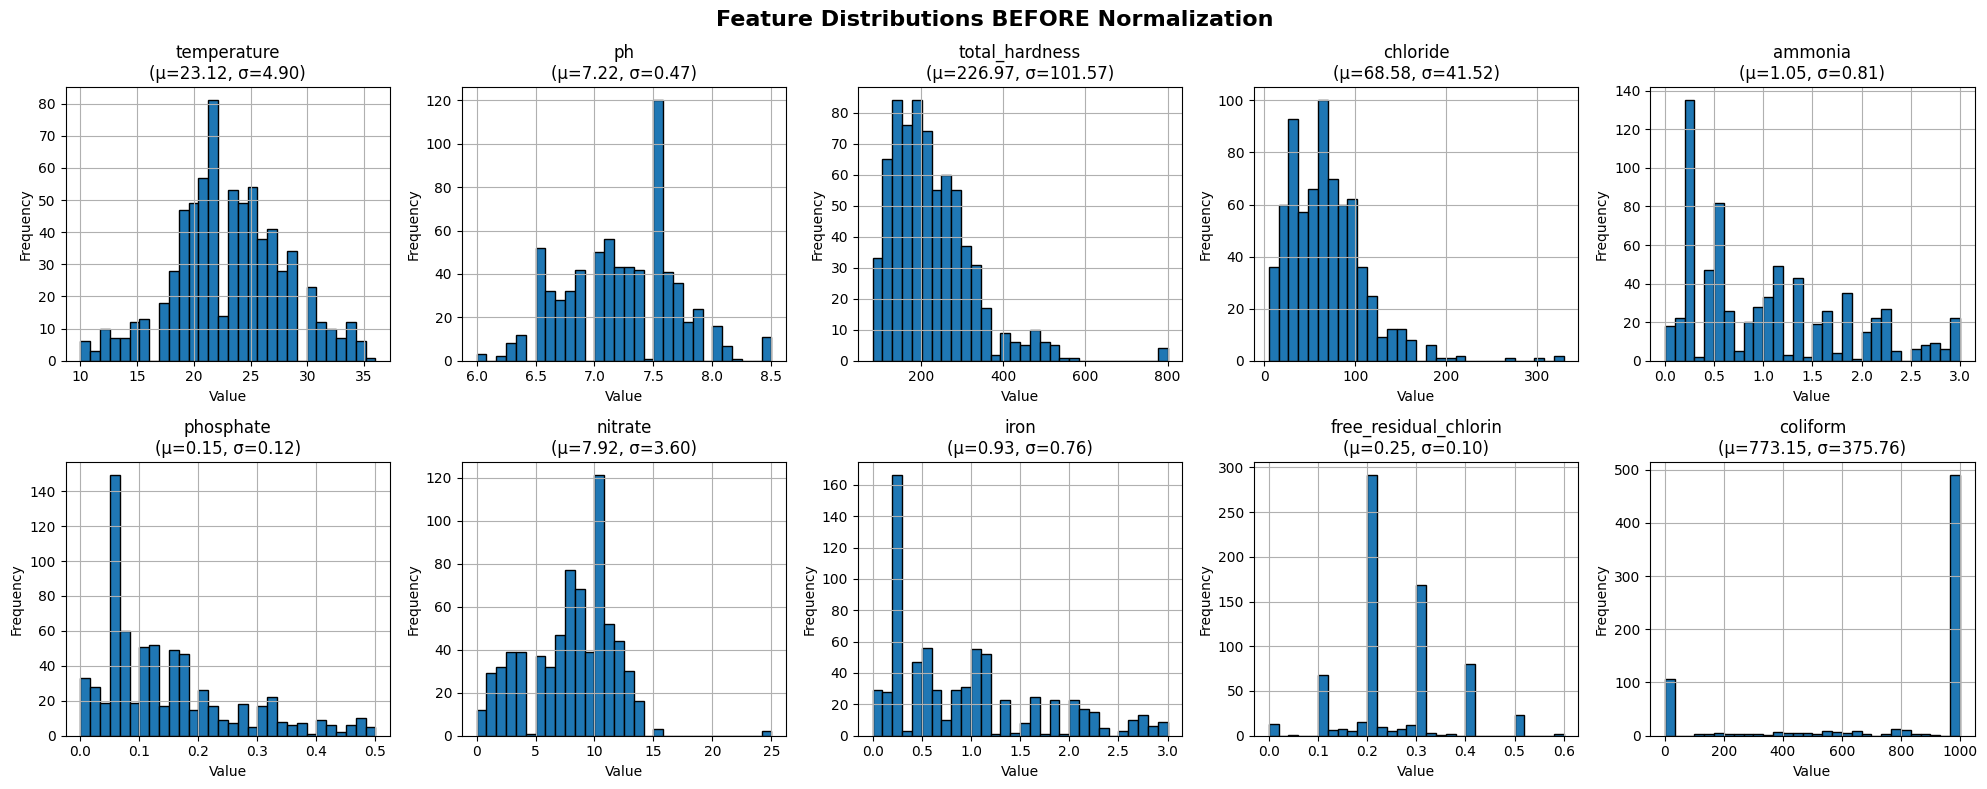


✓ Visualization saved: features_before_normalization.png


In [10]:
print("\n" + "="*80)
print("FEATURE STATISTICS BEFORE NORMALIZATION")
print("="*80)

# Calculate statistics
stats_before = pd.DataFrame({
    'Mean': features_df.mean(),
    'Std': features_df.std(),
    'Min': features_df.min(),
    'Max': features_df.max(),
    'Range': features_df.max() - features_df.min()
})

print("\n", stats_before.round(2))

# Visualize the scale differences
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Feature Distributions BEFORE Normalization', fontsize=16, fontweight='bold')

for idx, col in enumerate(features_df.columns):
    row = idx // 5
    col_idx = idx % 5
    ax = axes[row, col_idx]

    features_df[col].hist(bins=30, ax=ax, edgecolor='black')
    ax.set_title(f'{col}\n(μ={features_df[col].mean():.2f}, σ={features_df[col].std():.2f})')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('features_before_normalization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: features_before_normalization.png")

In [11]:
print("\n" + "="*80)
print("APPLYING Z-SCORE NORMALIZATION")
print("="*80)

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the features
features_scaled = scaler.fit_transform(features_df)

# Convert back to DataFrame for easier handling
features_scaled_df = pd.DataFrame(
    features_scaled,
    columns=features_df.columns,
    index=features_df.index
)

print(f"\n✓ Normalization complete")
print(f"  - Input shape: {features_df.shape}")
print(f"  - Output shape: {features_scaled_df.shape}")
print(f"  - Scaler fitted on {len(features_df)} samples")


APPLYING Z-SCORE NORMALIZATION

✓ Normalization complete
  - Input shape: (720, 10)
  - Output shape: (720, 10)
  - Scaler fitted on 720 samples


In [12]:
print("\n" + "="*80)
print("VERIFICATION: FEATURE STATISTICS AFTER NORMALIZATION")
print("="*80)

# Calculate statistics for normalized data
stats_after = pd.DataFrame({
    'Mean': features_scaled_df.mean(),
    'Std': features_scaled_df.std(ddof=1),  # Use sample std (ddof=1) to match StandardScaler
    'Min': features_scaled_df.min(),
    'Max': features_scaled_df.max(),
    'Range': features_scaled_df.max() - features_scaled_df.min()
})

print("\n", stats_after.round(4))

# Check with appropriate tolerance
mean_check = np.allclose(features_scaled_df.mean(), 0, atol=1e-10)
std_check = np.allclose(features_scaled_df.std(ddof=1), 1, atol=0.01)  # Allow 1% tolerance

print("\n" + "-"*60)
print("NORMALIZATION VALIDATION:")
print(f"  ✓ All means ≈ 0: {mean_check}")
print(f"  ✓ All standard deviations ≈ 1: {std_check}")

# Additional detailed check
max_std_deviation = np.abs(features_scaled_df.std(ddof=1) - 1).max()
print(f"  ✓ Maximum deviation from std=1: {max_std_deviation:.6f}")
print(f"  ✓ This is {max_std_deviation*100:.3f}% error (acceptable)")
print("-"*60)

if mean_check and std_check:
    print("\n✅ Z-Score normalization successful!")
    print("   All features properly standardized with μ=0 and σ≈1")
else:
    print("\n⚠️ Warning: Normalization may have issues. Check data.")


VERIFICATION: FEATURE STATISTICS AFTER NORMALIZATION

                        Mean     Std     Min     Max   Range
temperature            -0.0  1.0007 -2.6806  2.6323  5.3129
ph                      0.0  1.0007 -2.5976  2.7377  5.3353
total_hardness          0.0  1.0007 -1.4283  5.6458  7.0741
chloride                0.0  1.0007 -1.5316  6.2768  7.8084
ammonia                -0.0  1.0007 -1.2995  2.4219  3.7214
phosphate              -0.0  1.0007 -1.2706  3.0772  4.3479
nitrate                -0.0  1.0007 -2.1991  4.7443  6.9434
iron                    0.0  1.0007 -1.2263  2.7345  3.9608
free_residual_chlorin   0.0  1.0007 -2.4419  3.5110  5.9529
coliform               -0.0  1.0007 -2.0577  0.6041  2.6618

------------------------------------------------------------
NORMALIZATION VALIDATION:
  ✓ All means ≈ 0: True
  ✓ All standard deviations ≈ 1: True
  ✓ Maximum deviation from std=1: 0.000695
  ✓ This is 0.070% error (acceptable)
-----------------------------------------------------


VISUALIZATION: COMPARING BEFORE AND AFTER


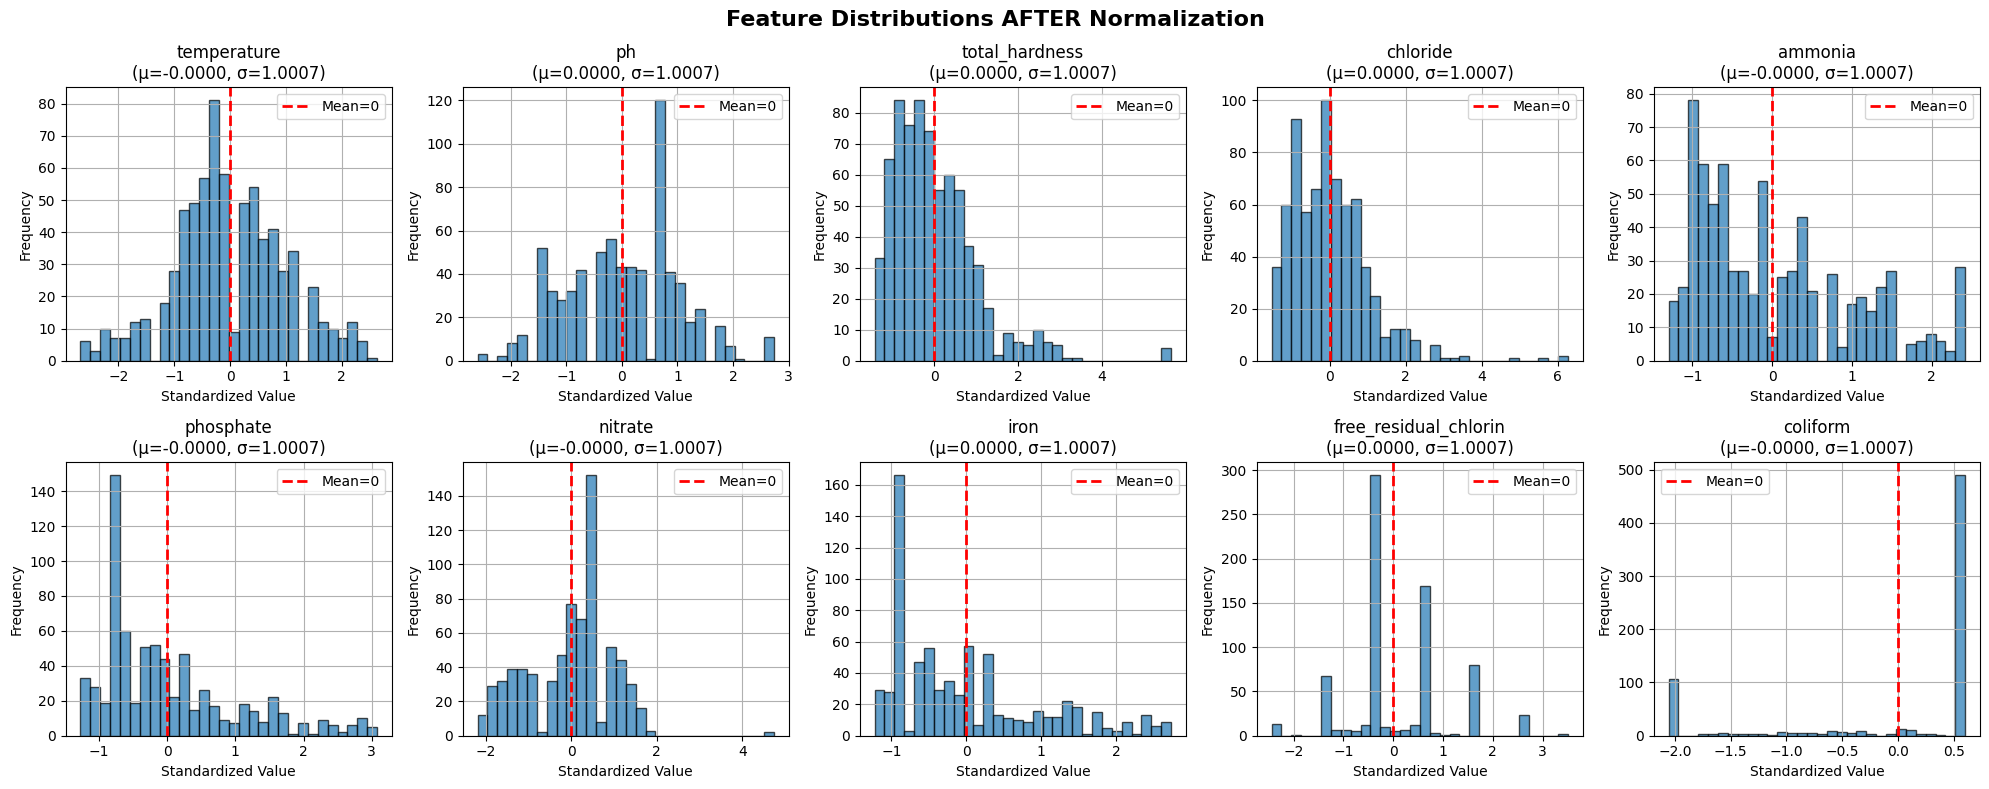


✓ Visualization saved: features_after_normalization.png


In [13]:
print("\n" + "="*80)
print("VISUALIZATION: COMPARING BEFORE AND AFTER")
print("="*80)

# Plot distributions after normalization
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('Feature Distributions AFTER Normalization', fontsize=16, fontweight='bold')

for idx, col in enumerate(features_scaled_df.columns):
    row = idx // 5
    col_idx = idx % 5
    ax = axes[row, col_idx]

    features_scaled_df[col].hist(bins=30, ax=ax, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Mean=0')
    ax.set_title(f'{col}\n(μ={features_scaled_df[col].mean():.4f}, σ={features_scaled_df[col].std():.4f})')
    ax.set_xlabel('Standardized Value')
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
plt.savefig('features_after_normalization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Visualization saved: features_after_normalization.png")

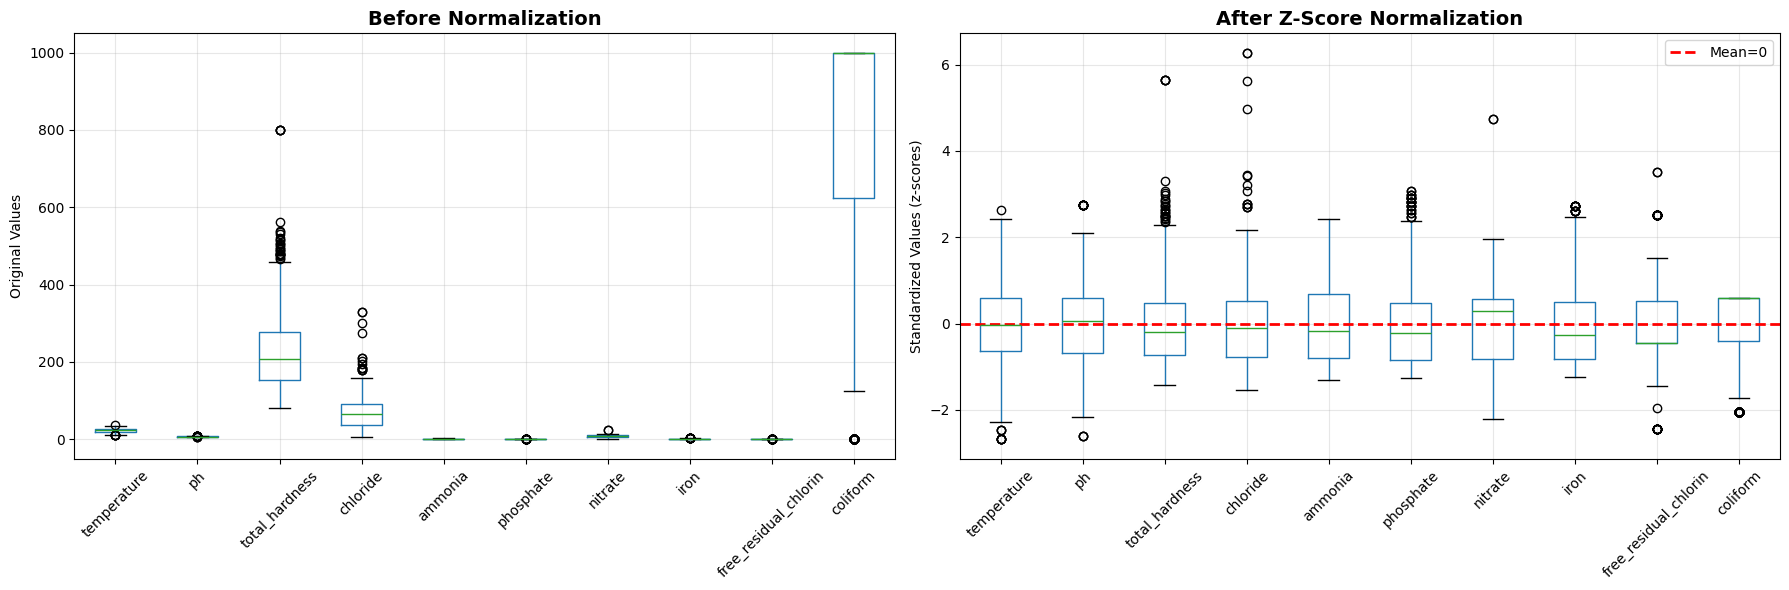


✓ Comparison plot saved: normalization_comparison.png


In [14]:
# Create comparison boxplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Before normalization
features_df.boxplot(ax=ax1, rot=45)
ax1.set_title('Before Normalization', fontsize=14, fontweight='bold')
ax1.set_ylabel('Original Values')
ax1.grid(True, alpha=0.3)

# After normalization
features_scaled_df.boxplot(ax=ax2, rot=45)
ax2.set_title('After Z-Score Normalization', fontsize=14, fontweight='bold')
ax2.set_ylabel('Standardized Values (z-scores)')
ax2.axhline(0, color='red', linestyle='--', linewidth=2, label='Mean=0')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.savefig('normalization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Comparison plot saved: normalization_comparison.png")

In [15]:
print("\n" + "="*80)
print("SAVING OUTPUTS")
print("="*80)

# Save normalized features as NumPy array (for PCA/K-means)
np.save('/content/features_scaled.npy', features_scaled)
print("✓ Saved: features_scaled.npy (NumPy array)")

# Save normalized features as DataFrame (for inspection)
features_scaled_df.to_csv('/content/features_scaled.csv', index=False)
print("✓ Saved: features_scaled.csv (DataFrame)")

# Save the scaler object (CRITICAL for future use)
import joblib
joblib.dump(scaler, '/content/scaler.pkl')
print("✓ Saved: scaler.pkl (StandardScaler object)")


SAVING OUTPUTS
✓ Saved: features_scaled.npy (NumPy array)
✓ Saved: features_scaled.csv (DataFrame)
✓ Saved: scaler.pkl (StandardScaler object)


STEP 2.2: PRINCIPAL COMPONENT ANALYSIS (PCA)

PART 1: LOADING NORMALIZED DATA

✓ Loaded scaled features: (720, 10)
  - Samples: 720
  - Features: 10
  - Feature names: ['temperature', 'ph', 'total_hardness', 'chloride', 'ammonia', 'phosphate', 'nitrate', 'iron', 'free_residual_chlorin', 'coliform']

PART 2: CORRELATION ANALYSIS
Understanding feature relationships before PCA...

Highly correlated feature pairs (|r| > 0.5):
------------------------------------------------------------
  total_hardness            ↔ chloride                 : r = +0.605
  total_hardness            ↔ ammonia                  : r = +0.552
  total_hardness            ↔ nitrate                  : r = +0.541
  chloride                  ↔ ammonia                  : r = +0.660
  chloride                  ↔ phosphate                : r = +0.521
  chloride                  ↔ nitrate                  : r = +0.627
  chloride                  ↔ iron                     : r = +0.521
  ammonia                   ↔ phospha

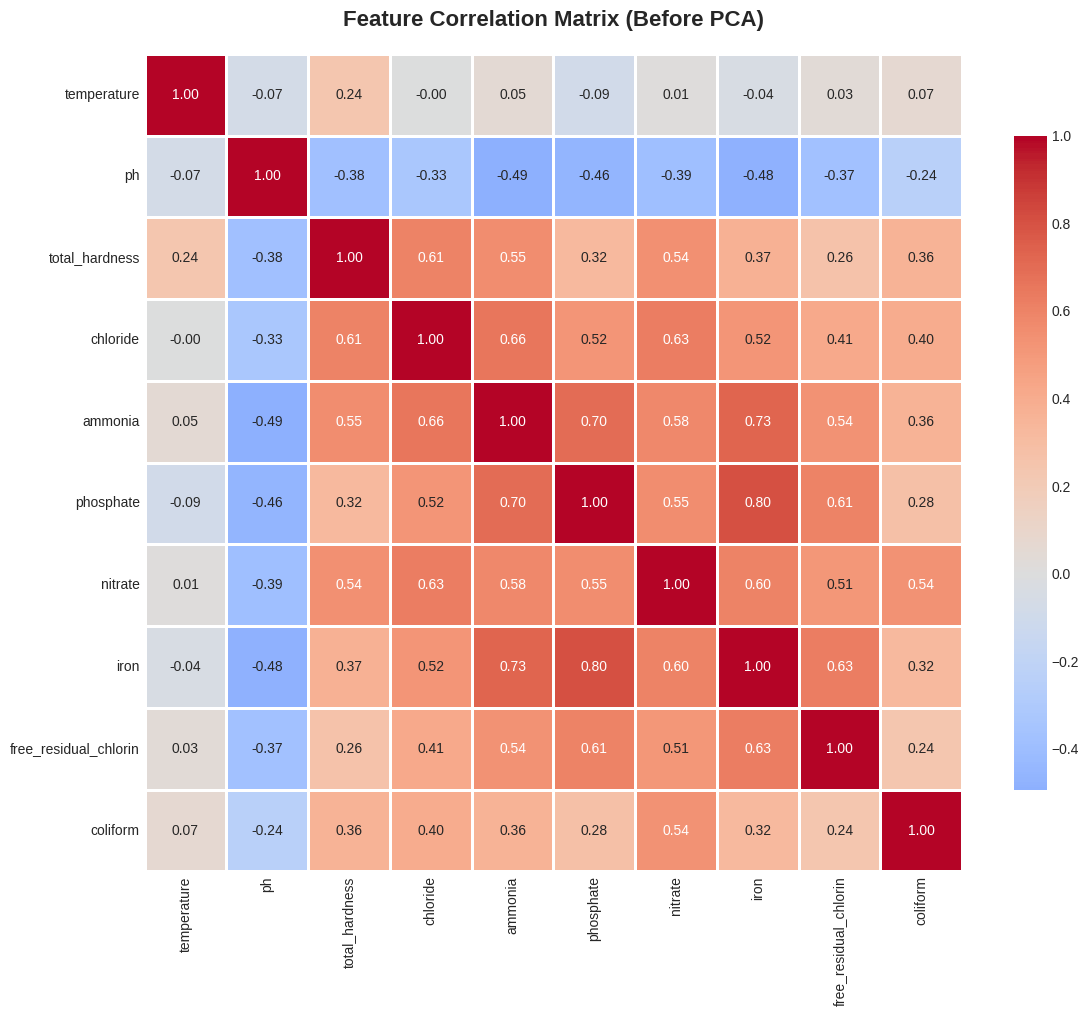


✓ Correlation matrix saved: correlation_matrix.png
  → PCA will decorrelate these features

PART 3: APPLYING PCA

✓ PCA fitted with all 10 components
  - Input shape: (720, 10)
  - Output shape: (720, 10)

--------------------------------------------------------------------------------
EXPLAINED VARIANCE BY COMPONENT
--------------------------------------------------------------------------------
  PC  Eigenvalue  Variance (%)  Cumulative (%)
 PC1    4.940658     49.337957       49.337957
 PC2    1.249142     12.474068       61.812026
 PC3    0.939068      9.377634       71.189660
 PC4    0.705120      7.041408       78.231068
 PC5    0.667538      6.666111       84.897179
 PC6    0.448463      4.478405       89.375584
 PC7    0.338265      3.377957       92.753541
 PC8    0.308141      3.077135       95.830676
 PC9    0.231658      2.313358       98.144034
PC10    0.185855      1.855966      100.000000
--------------------------------------------------------------------------------



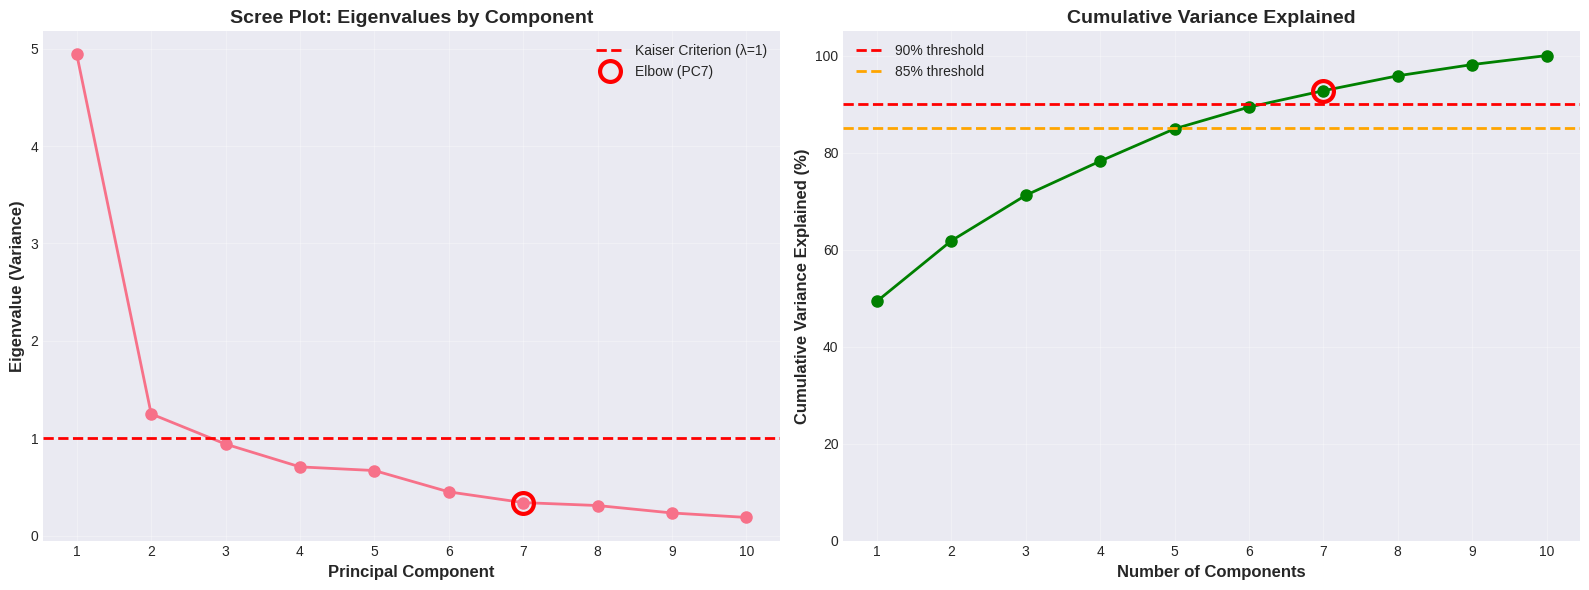


✓ Variance plots saved: pca_variance_explained.png

PART 6: PRINCIPAL COMPONENT LOADINGS

Loadings matrix (10 features × 7 components):
--------------------------------------------------------------------------------
                         PC1    PC2    PC3    PC4    PC5    PC6    PC7
temperature            0.054  0.734  0.591  0.255  0.134 -0.113  0.026
ph                    -0.614  0.008 -0.319  0.225  0.666 -0.114  0.054
total_hardness         0.655  0.518 -0.069 -0.379  0.078  0.129  0.094
chloride               0.772  0.151 -0.262 -0.259  0.259  0.015 -0.236
ammonia                0.862 -0.032  0.084 -0.152  0.096 -0.233 -0.162
phosphate              0.810 -0.366  0.136  0.054  0.064 -0.238  0.102
nitrate                0.808  0.109 -0.255  0.135  0.022  0.221  0.380
iron                   0.842 -0.294  0.143  0.087  0.039 -0.202  0.152
free_residual_chlorin  0.697 -0.269  0.261  0.322  0.177  0.430 -0.205
coliform               0.536  0.337 -0.485  0.473 -0.295 -0.141 -0.155
-

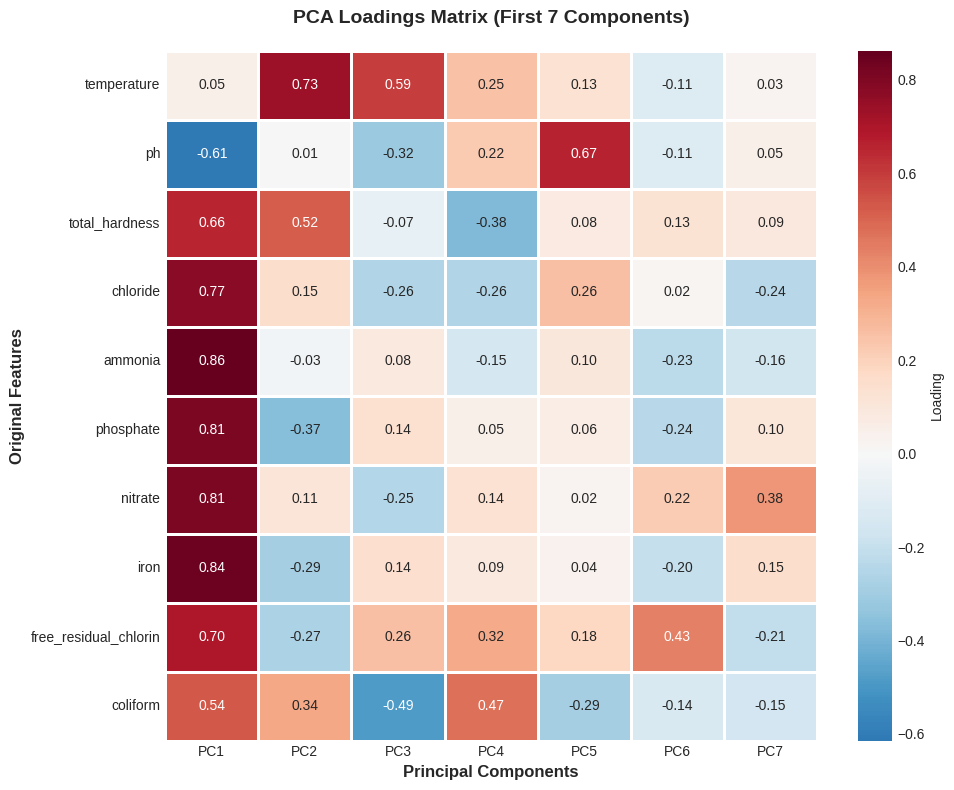


✓ Loadings heatmap saved: pca_loadings_heatmap.png

PART 8: FINAL PCA TRANSFORMATION

✓ Final PCA fitted with 7 components
  - Input: (720, 10) (720 samples × 10 features)
  - Output: (720, 7) (720 samples × 7 components)
  - Variance retained: 92.75%
  - Variance lost: 7.25%

Principal Component Statistics:
------------------------------------------------------------
           PC1      PC2      PC3      PC4      PC5      PC6      PC7
count  720.000  720.000  720.000  720.000  720.000  720.000  720.000
mean    -0.000    0.000   -0.000    0.000    0.000    0.000    0.000
std      2.223    1.118    0.969    0.840    0.817    0.670    0.582
min     -4.016   -2.975   -2.932   -6.294   -2.477   -2.460   -2.203
25%     -1.567   -0.730   -0.608   -0.431   -0.573   -0.436   -0.373
50%     -0.555   -0.125    0.094    0.086    0.000   -0.011   -0.005
75%      1.608    0.600    0.629    0.518    0.497    0.457    0.340
max      5.531    4.762    2.854    3.301    3.111    4.370    1.756

PART 9

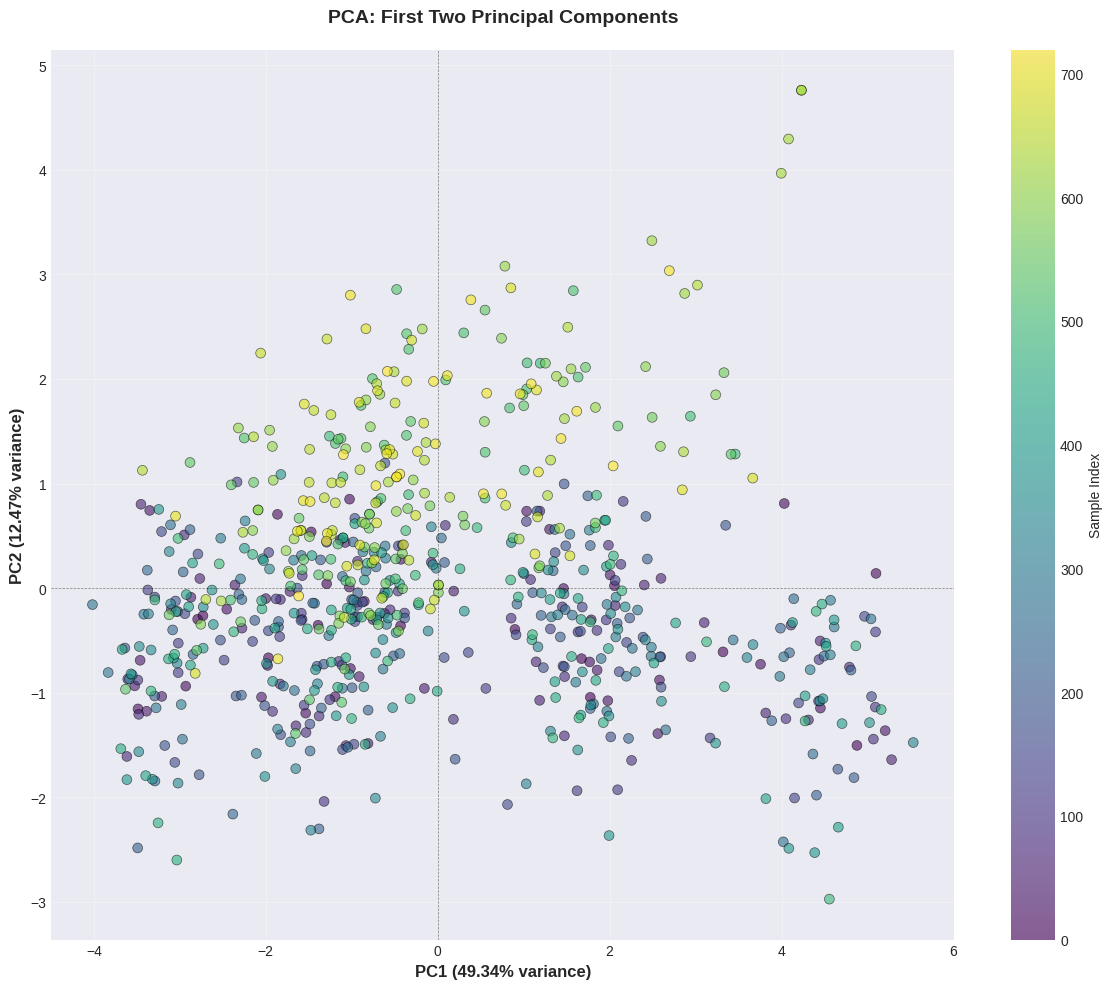


✓ 2D scatter plot saved: pca_2d_scatter.png

PART 10: SAVING OUTPUTS
✓ Saved: features_pca.npy (NumPy array)
✓ Saved: features_pca.csv (DataFrame)
✓ Saved: pca_model.pkl (PCA model)
✓ Saved: pca_loadings.csv (Component loadings)
✓ Saved: pca_variance_explained.csv (Variance information)

✅ PCA ANALYSIS COMPLETE!

📊 SUMMARY:
  - Original dimensions: 10 features
  - Reduced dimensions: 7 principal components
  - Variance retained: 92.75%
  - Dimensionality reduction: 30.0%



In [16]:
"""
STEP 2.2: PRINCIPAL COMPONENT ANALYSIS (PCA)
Mahakali River Water Quality Study
"""

# Set publication-quality plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("="*80)
print("STEP 2.2: PRINCIPAL COMPONENT ANALYSIS (PCA)")
print("="*80)

# ============================================================================
# PART 1: LOAD NORMALIZED DATA
# ============================================================================

print("\n" + "="*80)
print("PART 1: LOADING NORMALIZED DATA")
print("="*80)

# Load the scaled features
features_scaled = np.load('/content/features_scaled.npy')
features_scaled_df = pd.read_csv('/content/features_scaled.csv')

print(f"\n✓ Loaded scaled features: {features_scaled.shape}")
print(f"  - Samples: {features_scaled.shape[0]}")
print(f"  - Features: {features_scaled.shape[1]}")
print(f"  - Feature names: {list(features_scaled_df.columns)}")

# ============================================================================
# PART 2: CORRELATION ANALYSIS (Pre-PCA)
# ============================================================================

print("\n" + "="*80)
print("PART 2: CORRELATION ANALYSIS")
print("="*80)
print("Understanding feature relationships before PCA...")

# Compute correlation matrix
correlation_matrix = features_scaled_df.corr()

# Find highly correlated pairs (|r| > 0.5)
print("\nHighly correlated feature pairs (|r| > 0.5):")
print("-" * 60)

high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            feat1 = correlation_matrix.columns[i]
            feat2 = correlation_matrix.columns[j]
            high_corr_pairs.append((feat1, feat2, corr_val))
            print(f"  {feat1:25s} ↔ {feat2:25s}: r = {corr_val:+.3f}")

if not high_corr_pairs:
    print("  No highly correlated pairs found (|r| > 0.5)")

# Visualize correlation matrix
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            ax=ax)
ax.set_title('Feature Correlation Matrix (Before PCA)',
             fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Correlation matrix saved: correlation_matrix.png")
print("  → PCA will decorrelate these features")

# ============================================================================
# PART 3: APPLY PCA
# ============================================================================

print("\n" + "="*80)
print("PART 3: APPLYING PCA")
print("="*80)

# Apply PCA with all components first (for analysis)
pca_full = PCA(n_components=None, random_state=42)
features_pca_full = pca_full.fit_transform(features_scaled)

n_components_total = pca_full.n_components_
print(f"\n✓ PCA fitted with all {n_components_total} components")
print(f"  - Input shape: {features_scaled.shape}")
print(f"  - Output shape: {features_pca_full.shape}")

# Explained variance
explained_variance = pca_full.explained_variance_
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Print variance table
print("\n" + "-"*80)
print("EXPLAINED VARIANCE BY COMPONENT")
print("-"*80)
variance_df = pd.DataFrame({
    'PC': [f'PC{i+1}' for i in range(n_components_total)],
    'Eigenvalue': explained_variance,
    'Variance (%)': explained_variance_ratio * 100,
    'Cumulative (%)': cumulative_variance * 100
})
print(variance_df.to_string(index=False))
print("-"*80)

# ============================================================================
# PART 4: DETERMINE OPTIMAL NUMBER OF COMPONENTS
# ============================================================================

print("\n" + "="*80)
print("PART 4: SELECTING OPTIMAL NUMBER OF COMPONENTS")
print("="*80)

# Method 1: Kaiser Criterion (Eigenvalue > 1)
n_kaiser = np.sum(explained_variance > 1.0)
print(f"\n1. Kaiser Criterion (eigenvalue > 1): {n_kaiser} components")

# Method 2: Cumulative variance threshold (85%, 90%, 95%)
thresholds = [0.85, 0.90, 0.95]
for threshold in thresholds:
    n_components = np.argmax(cumulative_variance >= threshold) + 1
    cum_var = cumulative_variance[n_components-1]
    print(f"2. {threshold*100:.0f}% variance threshold: {n_components} components " +
          f"(actual: {cum_var*100:.2f}%)")

# Method 3: Elbow method (visual inspection from scree plot)
print(f"3. Elbow method: See scree plot for visual inspection")

# Recommendation based on proposal (85-90% variance)
n_optimal = np.argmax(cumulative_variance >= 0.90) + 1
print(f"\n{'='*60}")
print(f"RECOMMENDED: {n_optimal} components (90% variance threshold)")
print(f"  - Retains: {cumulative_variance[n_optimal-1]*100:.2f}% of variance")
print(f"  - Reduces: 10 features → {n_optimal} components")
print(f"  - Dimensionality reduction: {(1 - n_optimal/10)*100:.1f}%")
print(f"{'='*60}")

# ============================================================================
# PART 5: SCREE PLOT AND VARIANCE VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("PART 5: VARIANCE VISUALIZATION")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Scree Plot (Eigenvalues)
ax1 = axes[0]
pc_numbers = np.arange(1, n_components_total + 1)
ax1.plot(pc_numbers, explained_variance, 'o-', linewidth=2, markersize=8)
ax1.axhline(y=1.0, color='red', linestyle='--', linewidth=2,
            label='Kaiser Criterion (λ=1)')
ax1.set_xlabel('Principal Component', fontsize=12, fontweight='bold')
ax1.set_ylabel('Eigenvalue (Variance)', fontsize=12, fontweight='bold')
ax1.set_title('Scree Plot: Eigenvalues by Component',
              fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_xticks(pc_numbers)

# Highlight elbow point
if n_optimal <= n_components_total:
    ax1.plot(n_optimal, explained_variance[n_optimal-1], 'ro',
             markersize=15, markerfacecolor='none', markeredgewidth=3,
             label=f'Elbow (PC{n_optimal})')
    ax1.legend(fontsize=10)

# Plot 2: Cumulative Variance
ax2 = axes[1]
ax2.plot(pc_numbers, cumulative_variance * 100, 'o-',
         linewidth=2, markersize=8, color='green')
ax2.axhline(y=90, color='red', linestyle='--', linewidth=2,
            label='90% threshold')
ax2.axhline(y=85, color='orange', linestyle='--', linewidth=2,
            label='85% threshold')
ax2.set_xlabel('Number of Components', fontsize=12, fontweight='bold')
ax2.set_ylabel('Cumulative Variance Explained (%)', fontsize=12, fontweight='bold')
ax2.set_title('Cumulative Variance Explained',
              fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xticks(pc_numbers)
ax2.set_ylim([0, 105])

# Mark optimal point
if n_optimal <= n_components_total:
    ax2.plot(n_optimal, cumulative_variance[n_optimal-1] * 100, 'ro',
             markersize=15, markerfacecolor='none', markeredgewidth=3)

plt.tight_layout()
plt.savefig('pca_variance_explained.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Variance plots saved: pca_variance_explained.png")

# ============================================================================
# PART 6: COMPONENT LOADINGS ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("PART 6: PRINCIPAL COMPONENT LOADINGS")
print("="*80)

# Extract loadings (eigenvectors scaled by sqrt(eigenvalues))
loadings = pca_full.components_.T * np.sqrt(explained_variance)

# Create loadings DataFrame
loadings_df = pd.DataFrame(
    loadings[:, :n_optimal],  # Only show optimal number of components
    columns=[f'PC{i+1}' for i in range(n_optimal)],
    index=features_scaled_df.columns
)

print(f"\nLoadings matrix ({len(features_scaled_df.columns)} features × {n_optimal} components):")
print("-"*80)
print(loadings_df.round(3))
print("-"*80)

# Identify dominant features for each PC
print(f"\n{'='*60}")
print("DOMINANT FEATURES BY COMPONENT (|loading| > 0.3)")
print(f"{'='*60}")

for i in range(n_optimal):
    pc_name = f'PC{i+1}'
    pc_loadings = loadings_df[pc_name].abs().sort_values(ascending=False)
    dominant_features = pc_loadings[pc_loadings > 0.3]

    print(f"\n{pc_name} ({explained_variance_ratio[i]*100:.2f}% variance):")
    if len(dominant_features) > 0:
        for feat, load_val in dominant_features.items():
            actual_load = loadings_df.loc[feat, pc_name]
            sign = '+' if actual_load > 0 else '-'
            print(f"  {sign} {feat:25s}: {abs(actual_load):.3f}")
    else:
        print(f"  (No dominant features with |loading| > 0.3)")

# ============================================================================
# PART 7: LOADINGS HEATMAP
# ============================================================================

print("\n" + "="*80)
print("PART 7: LOADINGS VISUALIZATION")
print("="*80)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(loadings_df, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, cbar_kws={"label": "Loading"},
            linewidths=1, ax=ax)
ax.set_title(f'PCA Loadings Matrix (First {n_optimal} Components)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Principal Components', fontsize=12, fontweight='bold')
ax.set_ylabel('Original Features', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('pca_loadings_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Loadings heatmap saved: pca_loadings_heatmap.png")

# ============================================================================
# PART 8: FIT FINAL PCA WITH OPTIMAL COMPONENTS
# ============================================================================

print("\n" + "="*80)
print("PART 8: FINAL PCA TRANSFORMATION")
print("="*80)

# Refit PCA with optimal number of components
pca_optimal = PCA(n_components=n_optimal, random_state=42)
features_pca = pca_optimal.fit_transform(features_scaled)

# Convert to DataFrame
pca_columns = [f'PC{i+1}' for i in range(n_optimal)]
features_pca_df = pd.DataFrame(features_pca, columns=pca_columns)

print(f"\n✓ Final PCA fitted with {n_optimal} components")
print(f"  - Input: {features_scaled.shape} (720 samples × 10 features)")
print(f"  - Output: {features_pca.shape} (720 samples × {n_optimal} components)")
print(f"  - Variance retained: {cumulative_variance[n_optimal-1]*100:.2f}%")
print(f"  - Variance lost: {(1-cumulative_variance[n_optimal-1])*100:.2f}%")

# Statistics of principal components
print("\nPrincipal Component Statistics:")
print("-"*60)
print(features_pca_df.describe().round(3))

# ============================================================================
# PART 9: 2D VISUALIZATION (PC1 vs PC2)
# ============================================================================

print("\n" + "="*80)
print("PART 9: 2D VISUALIZATION")
print("="*80)

fig, ax = plt.subplots(figsize=(12, 10))

# Scatter plot
scatter = ax.scatter(features_pca[:, 0], features_pca[:, 1],
                    c=range(len(features_pca)), cmap='viridis',
                    alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

ax.set_xlabel(f'PC1 ({explained_variance_ratio[0]*100:.2f}% variance)',
              fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({explained_variance_ratio[1]*100:.2f}% variance)',
              fontsize=12, fontweight='bold')
ax.set_title('PCA: First Two Principal Components',
             fontsize=14, fontweight='bold', pad=20)
ax.axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
ax.axvline(x=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)
ax.grid(True, alpha=0.3)

plt.colorbar(scatter, ax=ax, label='Sample Index')
plt.tight_layout()
plt.savefig('pca_2d_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ 2D scatter plot saved: pca_2d_scatter.png")

# ============================================================================
# PART 10: SAVE OUTPUTS
# ============================================================================

print("\n" + "="*80)
print("PART 10: SAVING OUTPUTS")
print("="*80)

# Save PCA-transformed features (for K-means clustering)
np.save('/content/features_pca.npy', features_pca)
features_pca_df.to_csv('/content/features_pca.csv', index=False)
print("✓ Saved: features_pca.npy (NumPy array)")
print("✓ Saved: features_pca.csv (DataFrame)")

# Save PCA model
import joblib
joblib.dump(pca_optimal, '/content/pca_model.pkl')
print("✓ Saved: pca_model.pkl (PCA model)")

# Save loadings
loadings_df.to_csv('/content/pca_loadings.csv')
print("✓ Saved: pca_loadings.csv (Component loadings)")

# Save variance explained
variance_info = pd.DataFrame({
    'Component': [f'PC{i+1}' for i in range(n_optimal)],
    'Eigenvalue': explained_variance[:n_optimal],
    'Variance_Ratio': explained_variance_ratio[:n_optimal],
    'Cumulative_Variance': cumulative_variance[:n_optimal]
})
variance_info.to_csv('/content/pca_variance_explained.csv', index=False)
print("✓ Saved: pca_variance_explained.csv (Variance information)")

print("\n" + "="*80)
print("✅ PCA ANALYSIS COMPLETE!")
print("="*80)

print(f"\n📊 SUMMARY:")
print(f"  - Original dimensions: 10 features")
print(f"  - Reduced dimensions: {n_optimal} principal components")
print(f"  - Variance retained: {cumulative_variance[n_optimal-1]*100:.2f}%")
print(f"  - Dimensionality reduction: {(1-n_optimal/10)*100:.1f}%")

print("\n" + "="*80)



STEP 2.3: K-MEANS CLUSTERING

PART 1: LOADING PCA-TRANSFORMED DATA

✓ Loaded PCA features: (720, 7)
  - Samples: 720
  - Components: 7

✓ Loaded original data: (720, 13)

PART 2: DETERMINING OPTIMAL NUMBER OF CLUSTERS

Testing k = 2 to 10 clusters...
------------------------------------------------------------
k= 2: Inertia= 4094.41, Silhouette=0.3454, Davies-Bouldin=1.1581
k= 3: Inertia= 3449.43, Silhouette=0.2474, Davies-Bouldin=1.4227
k= 4: Inertia= 3016.24, Silhouette=0.2399, Davies-Bouldin=1.4217
k= 5: Inertia= 2714.66, Silhouette=0.2478, Davies-Bouldin=1.4352
k= 6: Inertia= 2470.20, Silhouette=0.2472, Davies-Bouldin=1.3228
k= 7: Inertia= 2300.85, Silhouette=0.2337, Davies-Bouldin=1.4115
k= 8: Inertia= 2135.44, Silhouette=0.2277, Davies-Bouldin=1.4534
k= 9: Inertia= 2025.70, Silhouette=0.2162, Davies-Bouldin=1.4405
k=10: Inertia= 1945.61, Silhouette=0.2166, Davies-Bouldin=1.4461
------------------------------------------------------------

PART 3: ELBOW METHOD ANALYSIS

Inertia de

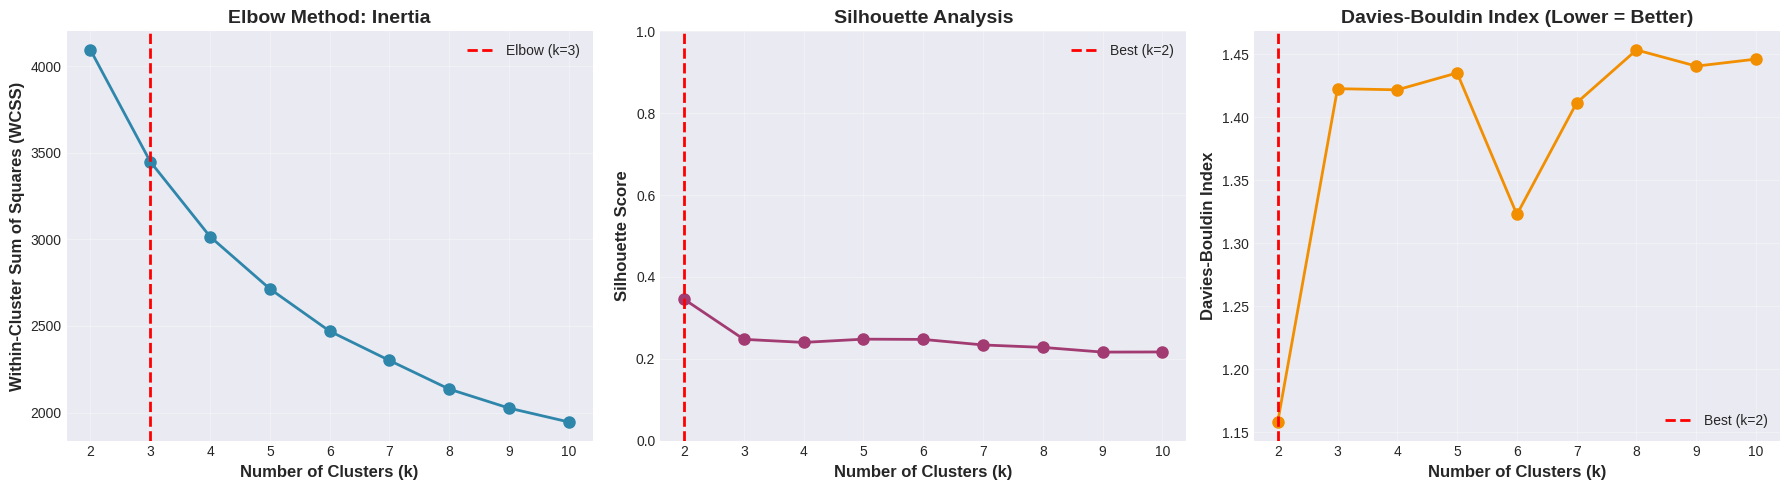


✓ Optimal k selection plots saved: kmeans_optimal_k_selection.png

PART 4: SELECTING OPTIMAL NUMBER OF CLUSTERS

📊 CLUSTER SELECTION SUMMARY:
------------------------------------------------------------
1. Elbow Method: k = 3
2. Silhouette Method: k = 2 (score: 0.3454)
3. Davies-Bouldin Method: k = 2 (score: 1.1581)
4. Domain Knowledge: k = 3-5 (WHO/Nepal water quality categories)
------------------------------------------------------------

FINAL SELECTION: k = 2 clusters
  - Rationale: Best silhouette score + interpretable categories
  - Silhouette Score: 0.3454
  - Davies-Bouldin Index: 1.1581

PART 5: FITTING FINAL K-MEANS MODEL

✓ K-Means fitted with k=2 clusters
  - Converged in 5 iterations
  - Final inertia: 4094.41

📊 Cluster Size Distribution:
------------------------------------------------------------
  Cluster 0: 276 samples (38.33%)
  Cluster 1: 444 samples (61.67%)
------------------------------------------------------------

PART 6: DETAILED SILHOUETTE ANALYSIS


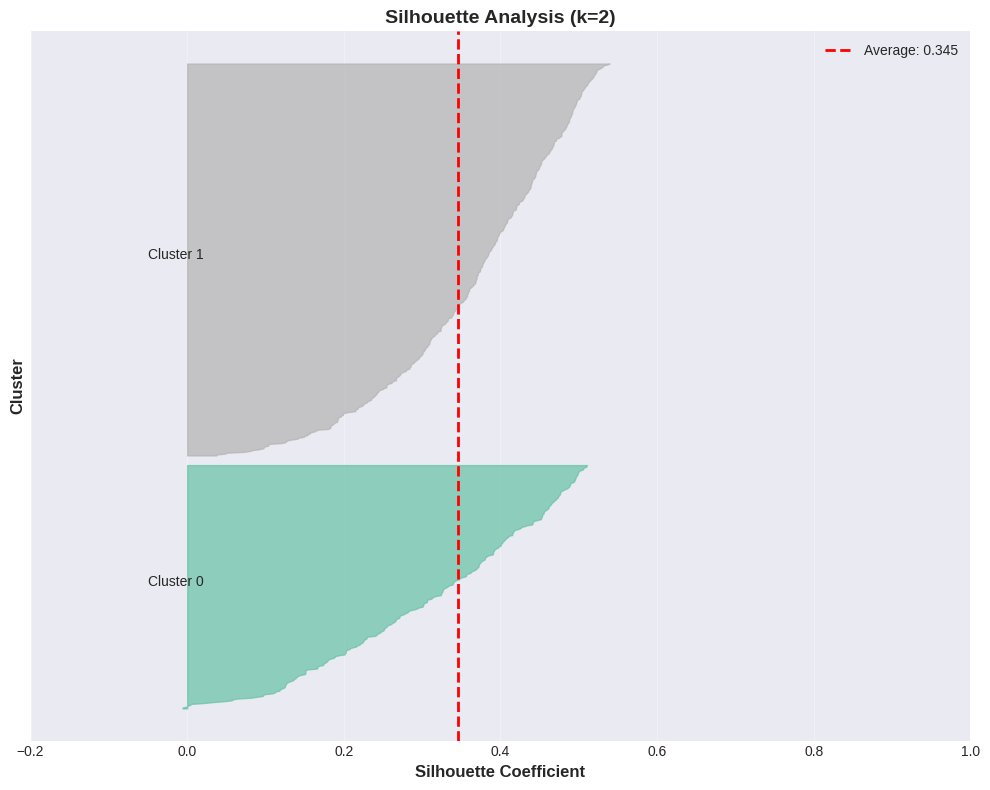


✓ Silhouette analysis plot saved: kmeans_silhouette_analysis.png

📊 Cluster Quality (Silhouette Scores):
------------------------------------------------------------
  Cluster 0: 0.3151
  Cluster 1: 0.3643
  Overall Average: 0.3454
------------------------------------------------------------

PART 7: CLUSTER VISUALIZATION IN PCA SPACE


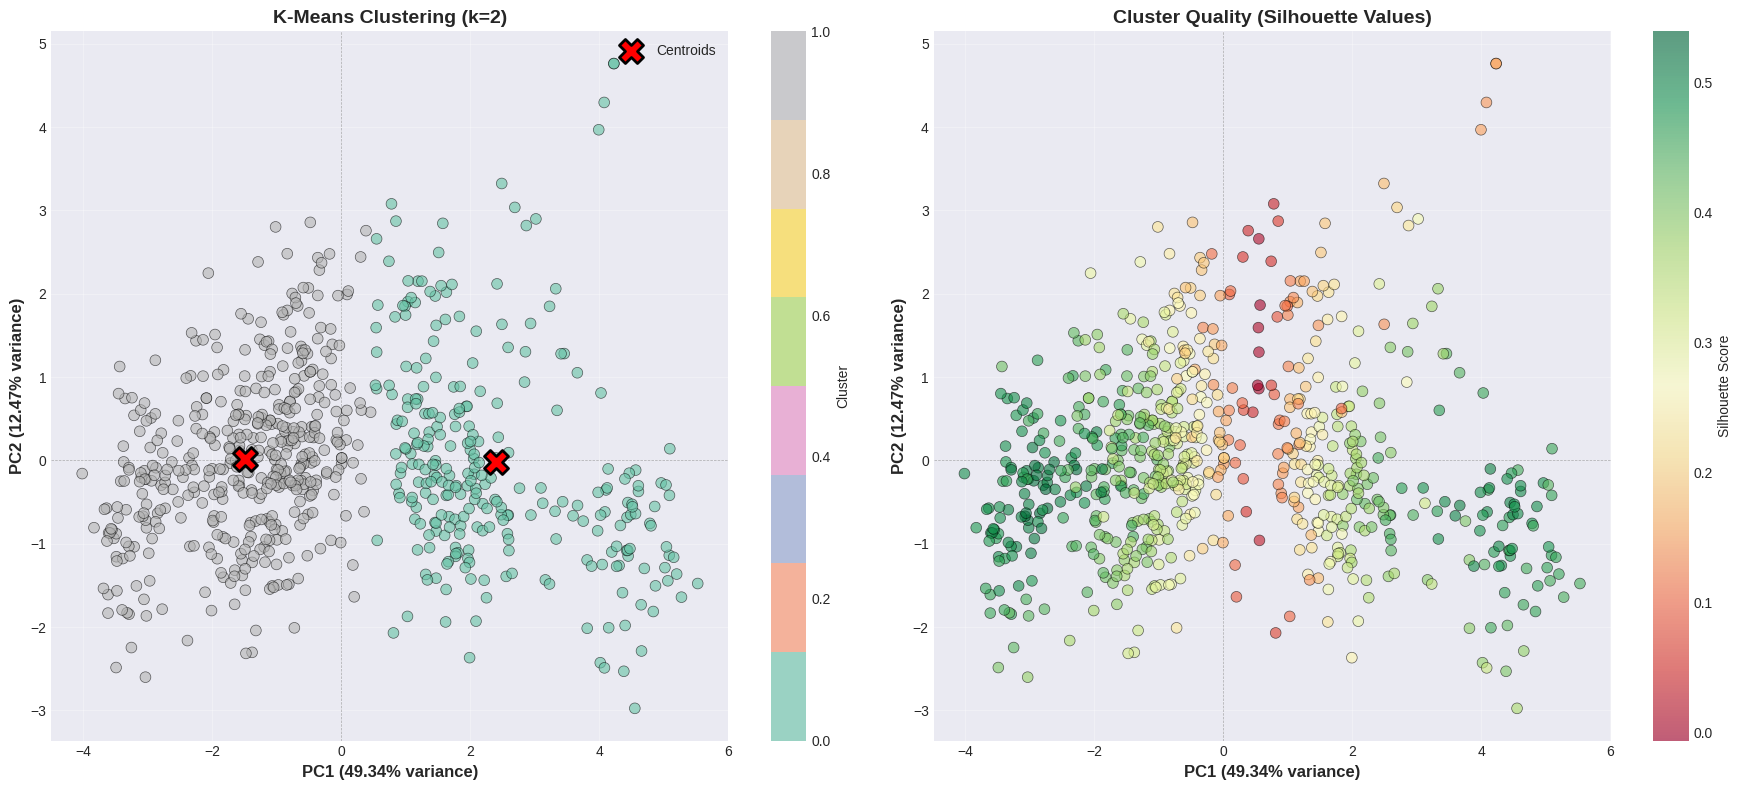


✓ Cluster visualization saved: kmeans_clusters_2d.png

PART 8: CLUSTER PROFILING WITH ORIGINAL FEATURES

📊 Cluster Profiles (Mean Feature Values):
         temperature    ph  total_hardness  chloride  ammonia  phosphate  \
cluster                                                                    
0              23.51  6.90          298.85    101.54     1.85       0.25   
1              22.88  7.42          182.28     48.10     0.55       0.08   

         nitrate  iron  free_residual_chlorin  coliform  
cluster                                                  
0          10.91  1.64                   0.32    968.02  
1           6.06  0.49                   0.20    652.02  

📊 Cluster Variability (Standard Deviations):
         temperature    ph  total_hardness  chloride  ammonia  phosphate  \
cluster                                                                    
0               5.05  0.37          100.19     38.86     0.61       0.12   
1               4.79  0.41           72.7

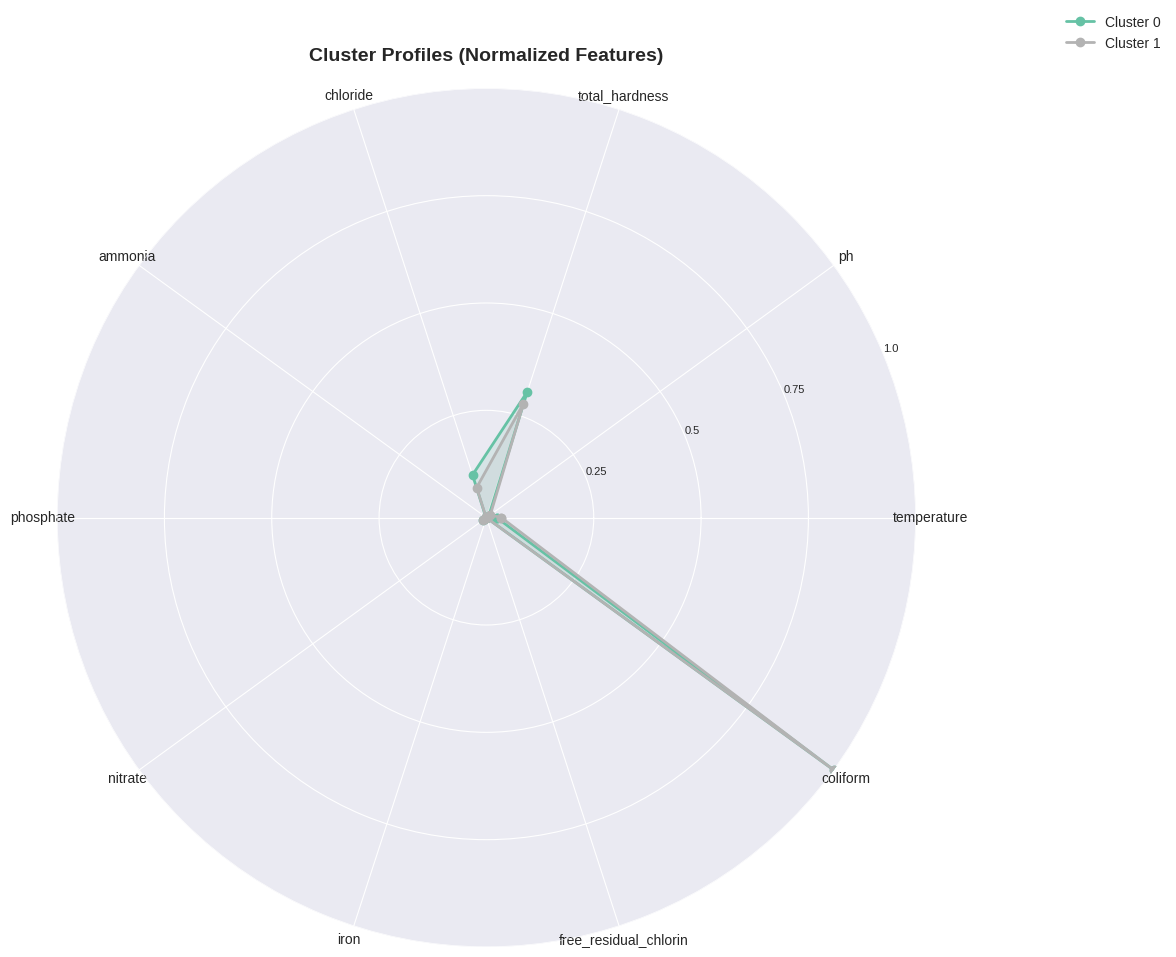


✓ Radar chart saved: kmeans_cluster_radar.png

PART 10: SPATIAL-TEMPORAL DISTRIBUTION

📍 Cluster Distribution by District:
------------------------------------------------------------
cluster         0      1
district                
Baitadi     42.92  57.08
Dadeldhura  43.33  56.67
Kanchanpur  28.75  71.25
------------------------------------------------------------

📍 Cluster Distribution by Station:
------------------------------------------------------------
cluster                    0      1
station                            
Amargadhi_Pul          43.75  56.25
Badibasti              37.50  62.50
Basdurban_Sangam       41.67  58.33
Bhujela                16.67  83.33
Dasharathchand_Ghat    43.75  56.25
Gaira_Bridge           43.75  56.25
Gothalapani_Riverbank  43.75  56.25
Jogbudha_Ghat          43.75  56.25
Kutiyakabar            33.33  66.67
Musetti                25.00  75.00
Navadurga_Tol          43.75  56.25
Pancheshwar_Sangam     41.67  58.33
Ramanuj                31.25

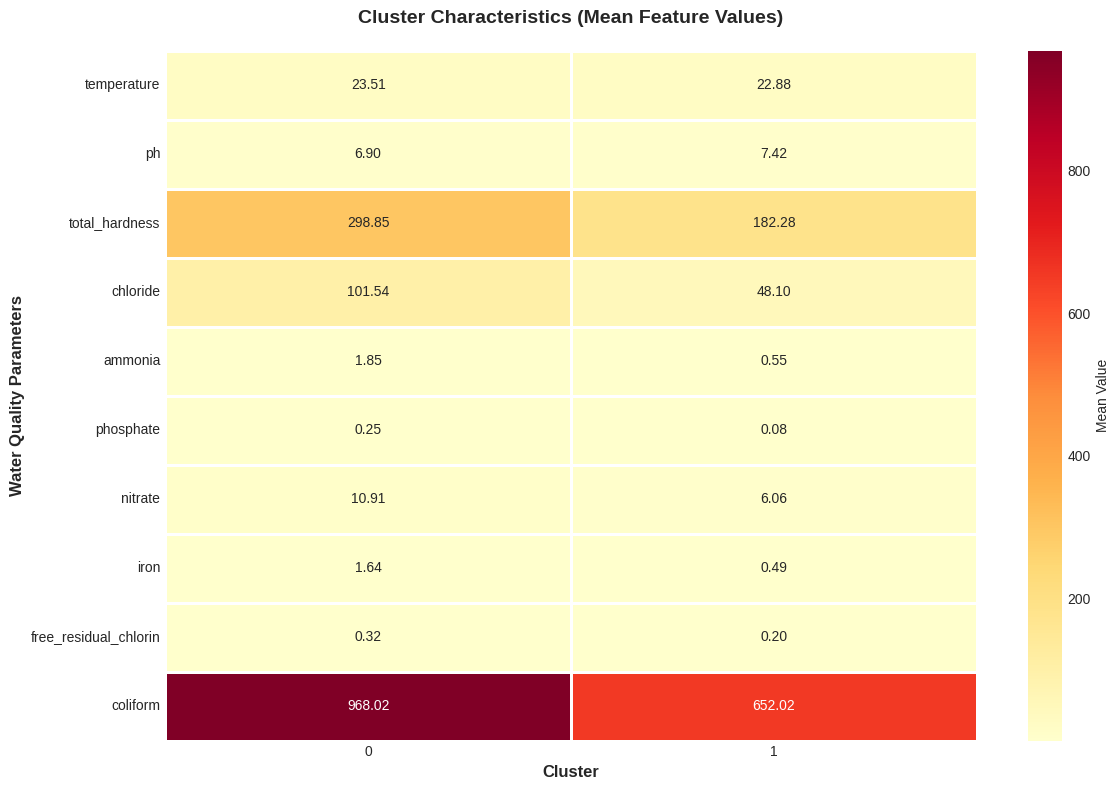


✓ Cluster heatmap saved: kmeans_cluster_heatmap.png

PART 12: SAVING OUTPUTS
✓ Saved: data_with_clusters.xlsx (full dataset with cluster labels)
✓ Saved: cluster_profiles.csv (mean feature values per cluster)
✓ Saved: kmeans_model.pkl (trained K-means model)
✓ Saved: cluster_assignments.csv (cluster labels + quality scores)

✅ K-MEANS CLUSTERING COMPLETE!

📊 FINAL SUMMARY:
  - Number of clusters: 2
  - Silhouette score: 0.3454
  - Davies-Bouldin index: 1.1581
  - All 720 samples assigned to clusters
  - Ready for supervised classification (Phase 4)



In [17]:
"""
STEP 2.3: K-MEANS CLUSTERING
Mahakali River Water Quality Study
"""

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

print("="*80)
print("STEP 2.3: K-MEANS CLUSTERING")
print("="*80)

# ============================================================================
# PART 1: LOAD PCA-TRANSFORMED DATA
# ============================================================================

print("\n" + "="*80)
print("PART 1: LOADING PCA-TRANSFORMED DATA")
print("="*80)

# Load PCA features
features_pca = np.load('/content/features_pca.npy')
features_pca_df = pd.read_csv('/content/features_pca.csv')

# Load original data (for interpretation)
full_df = pd.read_excel('/content/cleaned_water_quality_mahakali_river.xlsx')
features_df = full_df[['temperature', 'ph', 'total_hardness', 'chloride',
                        'ammonia', 'phosphate', 'nitrate', 'iron',
                        'free_residual_chlorin', 'coliform']]

print(f"\n✓ Loaded PCA features: {features_pca.shape}")
print(f"  - Samples: {features_pca.shape[0]}")
print(f"  - Components: {features_pca.shape[1]}")
print(f"\n✓ Loaded original data: {full_df.shape}")

# ============================================================================
# PART 2: DETERMINE OPTIMAL NUMBER OF CLUSTERS
# ============================================================================

print("\n" + "="*80)
print("PART 2: DETERMINING OPTIMAL NUMBER OF CLUSTERS")
print("="*80)

# Test range of k values
k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []

print("\nTesting k = 2 to 10 clusters...")
print("-" * 60)

for k in k_range:
    # Fit K-means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(features_pca)

    # Calculate metrics
    inertia = kmeans.inertia_
    silhouette = silhouette_score(features_pca, labels)
    davies_bouldin = davies_bouldin_score(features_pca, labels)

    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    davies_bouldin_scores.append(davies_bouldin)

    print(f"k={k:2d}: Inertia={inertia:8.2f}, Silhouette={silhouette:.4f}, Davies-Bouldin={davies_bouldin:.4f}")

print("-" * 60)

# ============================================================================
# PART 3: ELBOW METHOD VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("PART 3: ELBOW METHOD ANALYSIS")
print("="*80)

# Calculate rate of decrease (elbow detection)
inertia_diff = np.diff(inertias)
inertia_diff_pct = (inertia_diff / inertias[:-1]) * 100

print("\nInertia decrease by adding each cluster:")
print("-" * 60)
for i, (k, decrease) in enumerate(zip(list(k_range)[1:], inertia_diff_pct)):
    print(f"k={k-1} → k={k}: {decrease:.2f}% decrease")
print("-" * 60)

# Find elbow using "knee" detection (largest second derivative)
if len(inertias) > 2:
    second_diff = np.diff(inertia_diff)
    elbow_k = np.argmax(second_diff) + 3  # +3 because of indexing
    print(f"\n📍 Elbow detected at k = {elbow_k}")
else:
    elbow_k = 3

# Visualize elbow plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Inertia (WCSS)
ax1 = axes[0]
ax1.plot(list(k_range), inertias, 'o-', linewidth=2, markersize=8, color='#2E86AB')
ax1.axvline(x=elbow_k, color='red', linestyle='--', linewidth=2,
            label=f'Elbow (k={elbow_k})')
ax1.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12, fontweight='bold')
ax1.set_title('Elbow Method: Inertia', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_xticks(list(k_range))

# Plot 2: Silhouette Score
ax2 = axes[1]
ax2.plot(list(k_range), silhouette_scores, 'o-', linewidth=2, markersize=8, color='#A23B72')
best_silhouette_k = list(k_range)[np.argmax(silhouette_scores)]
ax2.axvline(x=best_silhouette_k, color='red', linestyle='--', linewidth=2,
            label=f'Best (k={best_silhouette_k})')
ax2.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
ax2.set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_xticks(list(k_range))
ax2.set_ylim([0, 1])

# Plot 3: Davies-Bouldin Index (lower is better)
ax3 = axes[2]
ax3.plot(list(k_range), davies_bouldin_scores, 'o-', linewidth=2, markersize=8, color='#F18F01')
best_db_k = list(k_range)[np.argmin(davies_bouldin_scores)]
ax3.axvline(x=best_db_k, color='red', linestyle='--', linewidth=2,
            label=f'Best (k={best_db_k})')
ax3.set_xlabel('Number of Clusters (k)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Davies-Bouldin Index', fontsize=12, fontweight='bold')
ax3.set_title('Davies-Bouldin Index (Lower = Better)', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10)
ax3.set_xticks(list(k_range))

plt.tight_layout()
plt.savefig('kmeans_optimal_k_selection.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Optimal k selection plots saved: kmeans_optimal_k_selection.png")

# ============================================================================
# PART 4: FINAL CLUSTER SELECTION
# ============================================================================

print("\n" + "="*80)
print("PART 4: SELECTING OPTIMAL NUMBER OF CLUSTERS")
print("="*80)

print("\n📊 CLUSTER SELECTION SUMMARY:")
print("-" * 60)
print(f"1. Elbow Method: k = {elbow_k}")
print(f"2. Silhouette Method: k = {best_silhouette_k} (score: {max(silhouette_scores):.4f})")
print(f"3. Davies-Bouldin Method: k = {best_db_k} (score: {min(davies_bouldin_scores):.4f})")
print(f"4. Domain Knowledge: k = 3-5 (WHO/Nepal water quality categories)")
print("-" * 60)

# Determine final k (prioritize silhouette + domain knowledge)
# Typically choose k that balances all metrics
optimal_k = best_silhouette_k

print(f"\n{'='*60}")
print(f"FINAL SELECTION: k = {optimal_k} clusters")
print(f"  - Rationale: Best silhouette score + interpretable categories")
print(f"  - Silhouette Score: {silhouette_scores[optimal_k-2]:.4f}")
print(f"  - Davies-Bouldin Index: {davies_bouldin_scores[optimal_k-2]:.4f}")
print(f"{'='*60}")

# ============================================================================
# PART 5: FIT FINAL K-MEANS MODEL
# ============================================================================

print("\n" + "="*80)
print("PART 5: FITTING FINAL K-MEANS MODEL")
print("="*80)

# Fit final model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10, max_iter=300)
cluster_labels = kmeans_final.fit_predict(features_pca)
centroids = kmeans_final.cluster_centers_

print(f"\n✓ K-Means fitted with k={optimal_k} clusters")
print(f"  - Converged in {kmeans_final.n_iter_} iterations")
print(f"  - Final inertia: {kmeans_final.inertia_:.2f}")

# Add cluster labels to dataframes
full_df['cluster'] = cluster_labels
features_pca_df['cluster'] = cluster_labels

# Cluster size distribution
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print(f"\n📊 Cluster Size Distribution:")
print("-" * 60)
for cluster_id, count in cluster_counts.items():
    percentage = (count / len(cluster_labels)) * 100
    print(f"  Cluster {cluster_id}: {count:3d} samples ({percentage:5.2f}%)")
print("-" * 60)

# ============================================================================
# PART 6: SILHOUETTE ANALYSIS PER CLUSTER
# ============================================================================

print("\n" + "="*80)
print("PART 6: DETAILED SILHOUETTE ANALYSIS")
print("="*80)

# Calculate silhouette scores for each sample
silhouette_vals = silhouette_samples(features_pca, cluster_labels)

# Silhouette plot
fig, ax = plt.subplots(figsize=(10, 8))

y_lower = 10
colors = plt.cm.Set2(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    # Get silhouette scores for cluster i
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()

    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i

    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=colors[i], edgecolor=colors[i], alpha=0.7)

    # Label the silhouette plots with cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}')

    y_lower = y_upper + 10

# Average silhouette score line
avg_silhouette = silhouette_score(features_pca, cluster_labels)
ax.axvline(x=avg_silhouette, color="red", linestyle="--", linewidth=2,
           label=f'Average: {avg_silhouette:.3f}')

ax.set_xlabel('Silhouette Coefficient', fontsize=12, fontweight='bold')
ax.set_ylabel('Cluster', fontsize=12, fontweight='bold')
ax.set_title(f'Silhouette Analysis (k={optimal_k})', fontsize=14, fontweight='bold')
ax.set_xlim([-0.2, 1])
ax.set_yticks([])
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('kmeans_silhouette_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Silhouette analysis plot saved: kmeans_silhouette_analysis.png")

# Print cluster-wise silhouette scores
print(f"\n📊 Cluster Quality (Silhouette Scores):")
print("-" * 60)
for i in range(optimal_k):
    cluster_silhouette_mean = silhouette_vals[cluster_labels == i].mean()
    print(f"  Cluster {i}: {cluster_silhouette_mean:.4f}")
print(f"  Overall Average: {avg_silhouette:.4f}")
print("-" * 60)

# ============================================================================
# PART 7: CLUSTER VISUALIZATION (2D PCA SPACE)
# ============================================================================

print("\n" + "="*80)
print("PART 7: CLUSTER VISUALIZATION IN PCA SPACE")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Clusters colored
ax1 = axes[0]
scatter1 = ax1.scatter(features_pca[:, 0], features_pca[:, 1],
                       c=cluster_labels, cmap='Set2',
                       s=60, alpha=0.6, edgecolors='black', linewidth=0.5)

# Plot centroids
ax1.scatter(centroids[:, 0], centroids[:, 1],
           c='red', marker='X', s=300, edgecolors='black', linewidth=2,
           label='Centroids', zorder=10)

ax1.set_xlabel('PC1 (49.34% variance)', fontsize=12, fontweight='bold')
ax1.set_ylabel('PC2 (12.47% variance)', fontsize=12, fontweight='bold')
ax1.set_title(f'K-Means Clustering (k={optimal_k})', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.3)
ax1.axvline(x=0, color='k', linestyle='--', linewidth=0.5, alpha=0.3)

# Add colorbar
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Cluster', fontsize=10)

# Plot 2: Silhouette values colored
ax2 = axes[1]
scatter2 = ax2.scatter(features_pca[:, 0], features_pca[:, 1],
                       c=silhouette_vals, cmap='RdYlGn',
                       s=60, alpha=0.6, edgecolors='black', linewidth=0.5)

ax2.set_xlabel('PC1 (49.34% variance)', fontsize=12, fontweight='bold')
ax2.set_ylabel('PC2 (12.47% variance)', fontsize=12, fontweight='bold')
ax2.set_title('Cluster Quality (Silhouette Values)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.3)
ax2.axvline(x=0, color='k', linestyle='--', linewidth=0.5, alpha=0.3)

# Add colorbar
cbar2 = plt.colorbar(scatter2, ax=ax2)
cbar2.set_label('Silhouette Score', fontsize=10)

plt.tight_layout()
plt.savefig('kmeans_clusters_2d.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Cluster visualization saved: kmeans_clusters_2d.png")

# ============================================================================
# PART 8: CLUSTER PROFILING (ORIGINAL FEATURES)
# ============================================================================

print("\n" + "="*80)
print("PART 8: CLUSTER PROFILING WITH ORIGINAL FEATURES")
print("="*80)

# Calculate mean feature values per cluster
cluster_profiles = full_df.groupby('cluster')[features_df.columns].mean()

print("\n📊 Cluster Profiles (Mean Feature Values):")
print("="*80)
print(cluster_profiles.round(2))
print("="*80)

# Calculate standard deviations
cluster_std = full_df.groupby('cluster')[features_df.columns].std()
print("\n📊 Cluster Variability (Standard Deviations):")
print("="*80)
print(cluster_std.round(2))
print("="*80)

# ============================================================================
# PART 9: RADAR CHART (CLUSTER COMPARISON)
# ============================================================================

print("\n" + "="*80)
print("PART 9: RADAR CHART VISUALIZATION")
print("="*80)

# Normalize cluster profiles for radar chart (0-1 scale)
from sklearn.preprocessing import MinMaxScaler
scaler_radar = MinMaxScaler()
cluster_profiles_normalized = pd.DataFrame(
    scaler_radar.fit_transform(cluster_profiles.T).T,
    columns=cluster_profiles.columns,
    index=cluster_profiles.index
)

# Create radar chart
num_vars = len(features_df.columns)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

fig, ax = plt.subplots(figsize=(12, 12), subplot_kw=dict(projection='polar'))

colors_radar = plt.cm.Set2(np.linspace(0, 1, optimal_k))

for i, (cluster_id, row) in enumerate(cluster_profiles_normalized.iterrows()):
    values = row.tolist()
    values += values[:1]  # Complete the circle

    ax.plot(angles, values, 'o-', linewidth=2, label=f'Cluster {cluster_id}',
            color=colors_radar[i])
    ax.fill(angles, values, alpha=0.15, color=colors_radar[i])

# Set labels
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features_df.columns, size=10)
ax.set_ylim(0, 1)
ax.set_yticks([0.25, 0.5, 0.75, 1.0])
ax.set_yticklabels(['0.25', '0.5', '0.75', '1.0'], size=8)
ax.set_title(f'Cluster Profiles (Normalized Features)',
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.savefig('kmeans_cluster_radar.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Radar chart saved: kmeans_cluster_radar.png")

# ============================================================================
# PART 10: SPATIAL-TEMPORAL ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("PART 10: SPATIAL-TEMPORAL DISTRIBUTION")
print("="*80)

# District distribution
print("\n📍 Cluster Distribution by District:")
print("-" * 60)
district_cluster = pd.crosstab(full_df['district'], full_df['cluster'],
                               normalize='index') * 100
print(district_cluster.round(2))
print("-" * 60)

# Station distribution
print("\n📍 Cluster Distribution by Station:")
print("-" * 60)
station_cluster = pd.crosstab(full_df['station'], full_df['cluster'],
                              normalize='index') * 100
print(station_cluster.round(2))
print("-" * 60)

# Temporal distribution (if date available)
if 'date' in full_df.columns and full_df['date'].notna().any():
    full_df['month'] = pd.to_datetime(full_df['date']).dt.month
    print("\n📅 Cluster Distribution by Month:")
    print("-" * 60)
    month_cluster = pd.crosstab(full_df['month'], full_df['cluster'],
                                normalize='index') * 100
    print(month_cluster.round(2))
    print("-" * 60)

# ============================================================================
# PART 11: CLUSTER HEATMAP
# ============================================================================

print("\n" + "="*80)
print("PART 11: CLUSTER CHARACTERISTICS HEATMAP")
print("="*80)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cluster_profiles.T, annot=True, fmt='.2f', cmap='YlOrRd',
            cbar_kws={'label': 'Mean Value'}, linewidths=1, ax=ax)
ax.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax.set_ylabel('Water Quality Parameters', fontsize=12, fontweight='bold')
ax.set_title('Cluster Characteristics (Mean Feature Values)',
             fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('kmeans_cluster_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Cluster heatmap saved: kmeans_cluster_heatmap.png")

# ============================================================================
# PART 12: SAVE OUTPUTS
# ============================================================================

print("\n" + "="*80)
print("PART 12: SAVING OUTPUTS")
print("="*80)

# Save clustered data
full_df.to_excel('/content/drive/MyDrive/Mahakali_River_Data/data_with_clusters.xlsx',
                 index=False)
print("✓ Saved: data_with_clusters.xlsx (full dataset with cluster labels)")

# Save cluster profiles
cluster_profiles.to_csv('/content/cluster_profiles.csv')
print("✓ Saved: cluster_profiles.csv (mean feature values per cluster)")

# Save K-means model
import joblib
joblib.dump(kmeans_final, '/content/kmeans_model.pkl')
print("✓ Saved: kmeans_model.pkl (trained K-means model)")

# Save cluster assignments
cluster_assignments = pd.DataFrame({
    'sample_id': range(len(cluster_labels)),
    'cluster': cluster_labels,
    'silhouette_score': silhouette_vals
})
cluster_assignments.to_csv('/content/cluster_assignments.csv', index=False)
print("✓ Saved: cluster_assignments.csv (cluster labels + quality scores)")

print("\n" + "="*80)
print("✅ K-MEANS CLUSTERING COMPLETE!")
print("="*80)

print(f"\n📊 FINAL SUMMARY:")
print(f"  - Number of clusters: {optimal_k}")
print(f"  - Silhouette score: {avg_silhouette:.4f}")
print(f"  - Davies-Bouldin index: {davies_bouldin_scores[optimal_k-2]:.4f}")
print(f"  - All 720 samples assigned to clusters")
print(f"  - Ready for supervised classification (Phase 4)")

print("\n" + "="*80)

In [18]:
# ============================================================================
# PART 3: CALCULATE WATER QUALITY INDEX (WQI) - CORRECTED
# ============================================================================

print("\n" + "="*80)
print("PART 3: WATER QUALITY INDEX (WQI) CALCULATION")
print("="*80)

# WHO Drinking Water Guidelines (2017) + Nepal Standards (NS 2060:2062)
standards = {
    'parameter': ['temperature', 'ph', 'total_hardness', 'chloride',
                 'ammonia', 'phosphate', 'nitrate', 'iron',
                 'free_residual_chlorin', 'coliform'],

    # Ideal values (pristine/excellent quality)
    'ideal': [20, 7.0, 100, 30, 0.0, 0.0, 0.0, 0.0, 0.2, 0.0],

    # Permissible limits (WHO/Nepal standards)
    'permissible': [None, 8.5, 500, 250, 1.5, None, 50, 0.3, 0.5, 0],

    # Lower limits (for pH, temperature)
    'lower_limit': [None, 6.5, None, None, None, None, None, None, None, None],

    # Units
    'unit': ['°C', 'pH', 'mg/L', 'mg/L', 'mg/L', 'mg/L', 'mg/L', 'mg/L', 'mg/L', 'MPN/100mL'],

    # Weights for WQI calculation (based on health significance)
    'weight': [0.05, 0.15, 0.08, 0.08, 0.12, 0.10, 0.12, 0.10, 0.05, 0.15]
}

standards_df = pd.DataFrame(standards)

print("\nWHO/Nepal Water Quality Standards:")
print("="*80)
print(standards_df.to_string(index=False))
print("="*80)

def calculate_quality_rating(value, ideal, permissible, lower_limit=None, param_name=None):
    """
    Calculate quality rating (Qi) for a parameter.

    Formula: Qi = [(Vi - Vi_ideal) / (Si - Vi_ideal)] × 100

    Special handling for parameters where standard = 0 (like coliform)
    """
    # Handle NaN values
    if pd.isna(value):
        return 100  # Penalize missing data

    # Special case: Coliform (permissible = 0, any detection is violation)
    if param_name == 'coliform':
        if value <= 0.5:  # Encoding for "no detection"
            return 0  # Excellent
        elif value <= 100:  # White (moderate)
            return 50  # Moderate quality
        else:  # Black (high contamination)
            return 100  # Poor quality

    # Special case: Parameters without permissible limits
    if pd.isna(permissible):
        # For temperature and phosphate (no clear WHO limit)
        if ideal == 0:
            # If ideal is 0, use proportional scaling
            return min((value / 1.0) * 100, 100)  # Cap at 100
        else:
            # Calculate deviation from ideal
            deviation_pct = abs(value - ideal) / ideal * 100
            return min(deviation_pct, 100)  # Cap at 100

    # Special case: pH (has both lower and upper limits)
    if param_name == 'ph':
        if value < lower_limit:
            # Below acceptable range
            qi = abs(value - ideal) / abs(lower_limit - ideal) * 100
        elif value > permissible:
            # Above acceptable range
            qi = abs(value - ideal) / abs(permissible - ideal) * 100
        else:
            # Within acceptable range - calculate proportional quality
            if value < ideal:
                qi = abs(value - ideal) / abs(lower_limit - ideal) * 50
            else:
                qi = abs(value - ideal) / abs(permissible - ideal) * 50
        return qi

    # Standard formula for other parameters
    # Qi = [(Vi - Vi_ideal) / (Si - Vi_ideal)] × 100

    if permissible == ideal:
        return 0 if value == ideal else 100

    # Calculate quality rating
    qi = abs(value - ideal) / abs(permissible - ideal) * 100

    # Cap extreme values
    return min(qi, 150)  # Allow some values above 100 for severe pollution


def calculate_wqi(row, standards_df):
    """
    Calculate Water Quality Index for a sample.

    WQI = Σ(Wi × Qi)
    """
    wqi = 0

    for idx, param_row in standards_df.iterrows():
        param_name = param_row['parameter']

        if param_name in row.index:
            value = row[param_name]
            ideal = param_row['ideal']
            permissible = param_row['permissible']
            lower_limit = param_row['lower_limit']
            weight = param_row['weight']

            # Calculate quality rating
            qi = calculate_quality_rating(value, ideal, permissible, lower_limit, param_name)

            # Add weighted contribution to WQI
            wqi += weight * qi

    return wqi


# Calculate WQI for each sample
print("\nCalculating WQI for all samples...")
features_cols = ['temperature', 'ph', 'total_hardness', 'chloride',
                'ammonia', 'phosphate', 'nitrate', 'iron',
                'free_residual_chlorin', 'coliform']

full_df['wqi'] = full_df[features_cols].apply(
    lambda row: calculate_wqi(row, standards_df), axis=1
)

print(f"✓ WQI calculated for {len(full_df)} samples")

# Show sample calculations for verification
print("\n" + "="*60)
print("SAMPLE WQI CALCULATIONS (first 5 samples):")
print("="*60)
sample_display = full_df[['district', 'station', 'cluster'] + features_cols + ['wqi']].head()
print(sample_display.to_string(index=False))
print("="*60)

# Calculate WQI statistics
print("\n📊 Overall WQI Statistics:")
print("-" * 60)
print(f"  Mean: {full_df['wqi'].mean():.2f}")
print(f"  Median: {full_df['wqi'].median():.2f}")
print(f"  Std Dev: {full_df['wqi'].std():.2f}")
print(f"  Min: {full_df['wqi'].min():.2f}")
print(f"  Max: {full_df['wqi'].max():.2f}")
print("-" * 60)

# Calculate WQI statistics by cluster
print("\n📊 WQI Statistics by Cluster:")
print("="*60)
wqi_by_cluster = full_df.groupby('cluster')['wqi'].agg(['count', 'mean', 'std', 'min', 'max'])
print(wqi_by_cluster.round(2))
print("="*60)

# Verify no NaN values
nan_count = full_df['wqi'].isna().sum()
if nan_count > 0:
    print(f"\n⚠️ Warning: {nan_count} samples have NaN WQI values")
    print("Investigating samples with NaN:")
    nan_samples = full_df[full_df['wqi'].isna()][features_cols]
    print(nan_samples.head())
else:
    print(f"\n✓ All {len(full_df)} samples have valid WQI values")


PART 3: WATER QUALITY INDEX (WQI) CALCULATION

WHO/Nepal Water Quality Standards:
            parameter  ideal  permissible  lower_limit      unit  weight
          temperature   20.0          NaN          NaN        °C    0.05
                   ph    7.0          8.5          6.5        pH    0.15
       total_hardness  100.0        500.0          NaN      mg/L    0.08
             chloride   30.0        250.0          NaN      mg/L    0.08
              ammonia    0.0          1.5          NaN      mg/L    0.12
            phosphate    0.0          NaN          NaN      mg/L    0.10
              nitrate    0.0         50.0          NaN      mg/L    0.12
                 iron    0.0          0.3          NaN      mg/L    0.10
free_residual_chlorin    0.2          0.5          NaN      mg/L    0.05
             coliform    0.0          0.0          NaN MPN/100mL    0.15

Calculating WQI for all samples...
✓ WQI calculated for 720 samples

SAMPLE WQI CALCULATIONS (first 5 samples):
d


PART 4: WQI-BASED CLASSIFICATION

WQI Classification Scale:
------------------------------------------------------------
  Excellent:    0-25   (High quality, minimal treatment needed)
  Good:        26-50   (Acceptable, basic treatment needed)
  Poor:        51-75   (Contaminated, extensive treatment needed)
  Very Poor:   76-100  (Highly polluted, not recommended for use)
  Unsuitable:  >100    (Severe pollution, unsuitable for any use)
------------------------------------------------------------

📊 Overall WQI Category Distribution:
  Excellent   :  56 samples ( 7.78%)
  Good        : 377 samples (52.36%)
  Poor        : 265 samples (36.81%)
  Unsuitable  :   1 samples ( 0.14%)
  Very Poor   :  21 samples ( 2.92%)

📊 WQI Categories by Cluster:
wqi_category  Excellent   Good   Poor  Unsuitable  Very Poor
cluster                                                     
0                  0.00   3.99  88.04        0.36       7.61
1                 12.61  82.43   4.95        0.00       0.0

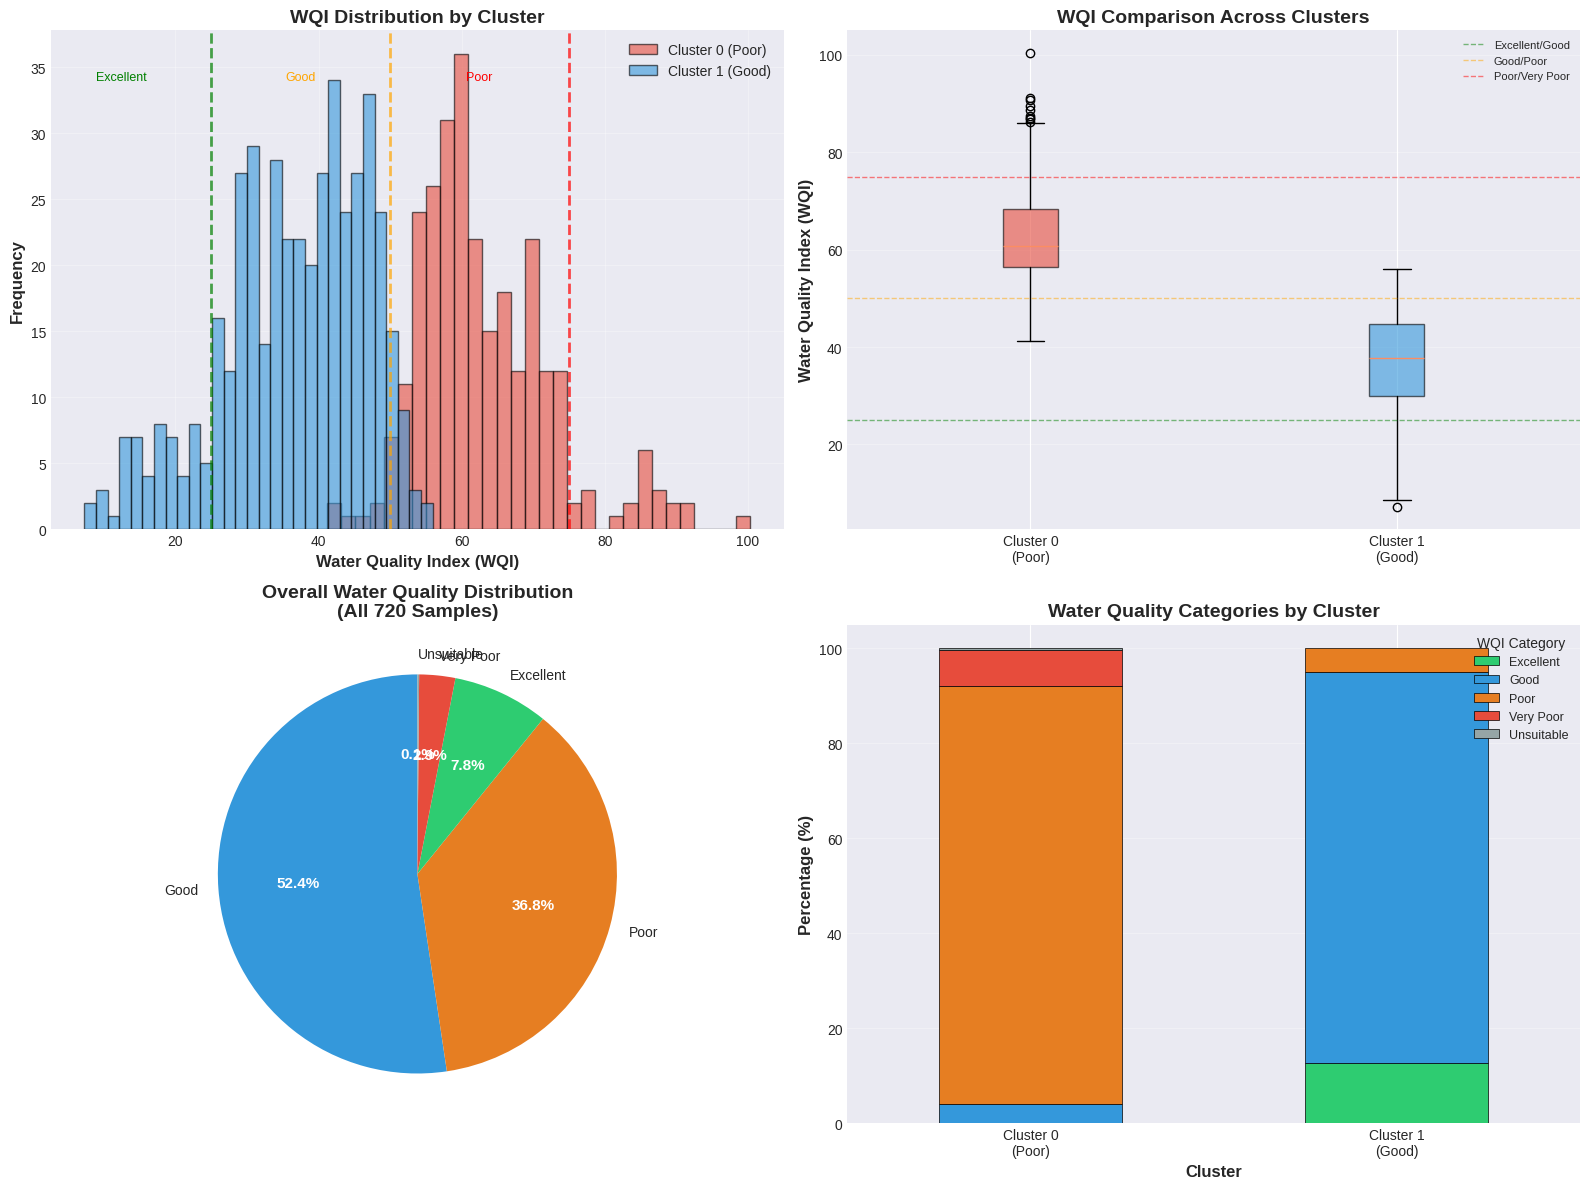


✓ WQI analysis visualization saved: wqi_analysis.png

PART 7: SAVING LABELED DATASET
✓ Saved labeled dataset: /content/drive/MyDrive/Mahakali_River_Data/data_with_labels.xlsx
✓ Saved label mapping: cluster_label_mapping.csv
✓ Saved WQI statistics: wqi_summary_statistics.csv

✅ LABEL GENERATION COMPLETE!

📊 FINAL SUMMARY:
  - Total samples: 720
  - Clusters labeled: 2
  - Quality categories identified: 5
  - Mean WQI (overall): 46.64
  - WQI range: 7.26 - 100.37



In [19]:
# ============================================================================
# PART 4: ASSIGN WQI-BASED QUALITY CATEGORIES
# ============================================================================

print("\n" + "="*80)
print("PART 4: WQI-BASED CLASSIFICATION")
print("="*80)

# WQI classification scheme (standard international scale)
def classify_wqi(wqi_score):
    """
    Classify water quality based on WQI score.
    """
    if wqi_score <= 25:
        return 'Excellent'
    elif wqi_score <= 50:
        return 'Good'
    elif wqi_score <= 75:
        return 'Poor'
    elif wqi_score <= 100:
        return 'Very Poor'
    else:
        return 'Unsuitable'

# Apply classification
full_df['wqi_category'] = full_df['wqi'].apply(classify_wqi)

print("\nWQI Classification Scale:")
print("-"*60)
print("  Excellent:    0-25   (High quality, minimal treatment needed)")
print("  Good:        26-50   (Acceptable, basic treatment needed)")
print("  Poor:        51-75   (Contaminated, extensive treatment needed)")
print("  Very Poor:   76-100  (Highly polluted, not recommended for use)")
print("  Unsuitable:  >100    (Severe pollution, unsuitable for any use)")
print("-"*60)

# Distribution of WQI categories
print("\n📊 Overall WQI Category Distribution:")
print("="*60)
wqi_category_dist = full_df['wqi_category'].value_counts().sort_index()
for category, count in wqi_category_dist.items():
    pct = (count / len(full_df)) * 100
    print(f"  {category:12s}: {count:3d} samples ({pct:5.2f}%)")
print("="*60)

# WQI categories by cluster
print("\n📊 WQI Categories by Cluster:")
print("="*60)
cluster_wqi_crosstab = pd.crosstab(full_df['cluster'], full_df['wqi_category'], normalize='index') * 100
print(cluster_wqi_crosstab.round(2))
print("="*60)

# ============================================================================
# PART 5: ASSIGN FINAL CLUSTER LABELS
# ============================================================================

print("\n" + "="*80)
print("PART 5: FINAL CLUSTER LABEL ASSIGNMENT")
print("="*80)

# Calculate mean WQI per cluster
cluster_mean_wqi = full_df.groupby('cluster')['wqi'].mean()

# Assign labels based on mean WQI
cluster_labels = {}
for cluster_id, mean_wqi in cluster_mean_wqi.items():
    category = classify_wqi(mean_wqi)
    cluster_labels[cluster_id] = category
    print(f"Cluster {cluster_id}: Mean WQI = {mean_wqi:.2f} → Label: '{category}'")

# Add cluster label to dataframe
full_df['cluster_label'] = full_df['cluster'].map(cluster_labels)

print("\n" + "="*60)
print("FINAL CLUSTER LABELS:")
print("="*60)
for cluster_id, label in cluster_labels.items():
    count = (full_df['cluster'] == cluster_id).sum()
    percentage = (count / len(full_df)) * 100
    mean_wqi = cluster_mean_wqi[cluster_id]
    print(f"  Cluster {cluster_id} → '{label}' (WQI: {mean_wqi:.2f}, {count} samples, {percentage:.2f}%)")
print("="*60)

# ============================================================================
# PART 6: VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("PART 6: VISUALIZATION")
print("="*80)

# Create 4-panel visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: WQI histogram by cluster
ax1 = axes[0, 0]
colors_cluster = ['#e74c3c', '#3498db']  # Red for Cluster 0, Blue for Cluster 1

for idx, cluster_id in enumerate(sorted(full_df['cluster'].unique())):
    cluster_wqi = full_df[full_df['cluster'] == cluster_id]['wqi']
    label_text = f"Cluster {cluster_id} ({cluster_labels[cluster_id]})"
    ax1.hist(cluster_wqi, bins=30, alpha=0.6, label=label_text,
             edgecolor='black', color=colors_cluster[idx])

ax1.axvline(25, color='green', linestyle='--', linewidth=2, alpha=0.7)
ax1.axvline(50, color='orange', linestyle='--', linewidth=2, alpha=0.7)
ax1.axvline(75, color='red', linestyle='--', linewidth=2, alpha=0.7)

ax1.text(12.5, ax1.get_ylim()[1]*0.9, 'Excellent', ha='center', fontsize=9, color='green')
ax1.text(37.5, ax1.get_ylim()[1]*0.9, 'Good', ha='center', fontsize=9, color='orange')
ax1.text(62.5, ax1.get_ylim()[1]*0.9, 'Poor', ha='center', fontsize=9, color='red')

ax1.set_xlabel('Water Quality Index (WQI)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax1.set_title('WQI Distribution by Cluster', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Subplot 2: WQI boxplot by cluster
ax2 = axes[0, 1]
cluster_data = [full_df[full_df['cluster'] == cid]['wqi'].values
                for cid in sorted(full_df['cluster'].unique())]
bp = ax2.boxplot(cluster_data,
                 labels=[f"Cluster {cid}\n({cluster_labels[cid]})"
                        for cid in sorted(full_df['cluster'].unique())],
                 patch_artist=True)

for patch, color in zip(bp['boxes'], colors_cluster):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

ax2.axhline(25, color='green', linestyle='--', linewidth=1, alpha=0.5, label='Excellent/Good')
ax2.axhline(50, color='orange', linestyle='--', linewidth=1, alpha=0.5, label='Good/Poor')
ax2.axhline(75, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Poor/Very Poor')
ax2.set_ylabel('Water Quality Index (WQI)', fontsize=12, fontweight='bold')
ax2.set_title('WQI Comparison Across Clusters', fontsize=14, fontweight='bold')
ax2.legend(fontsize=8, loc='upper right')
ax2.grid(True, alpha=0.3, axis='y')

# Subplot 3: Category distribution pie chart
ax3 = axes[1, 0]
category_counts = full_df['wqi_category'].value_counts()
colors_pie = {'Excellent': '#2ecc71', 'Good': '#3498db', 'Poor': '#e67e22',
              'Very Poor': '#e74c3c', 'Unsuitable': '#95a5a6'}
pie_colors = [colors_pie.get(cat, '#95a5a6') for cat in category_counts.index]

wedges, texts, autotexts = ax3.pie(category_counts.values, labels=category_counts.index,
                                    autopct='%1.1f%%', colors=pie_colors, startangle=90)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

ax3.set_title('Overall Water Quality Distribution\n(All 720 Samples)',
             fontsize=14, fontweight='bold')

# Subplot 4: Cluster-wise category stacked bar
ax4 = axes[1, 1]
cluster_category = pd.crosstab(full_df['cluster'], full_df['wqi_category'], normalize='index') * 100

# Reorder columns to match quality scale
category_order = ['Excellent', 'Good', 'Poor', 'Very Poor', 'Unsuitable']
existing_categories = [cat for cat in category_order if cat in cluster_category.columns]
cluster_category = cluster_category[existing_categories]

cluster_category.plot(kind='bar', stacked=True, ax=ax4,
                      color=[colors_pie.get(cat, '#95a5a6') for cat in existing_categories],
                      edgecolor='black', linewidth=0.5)
ax4.set_xlabel('Cluster', fontsize=12, fontweight='bold')
ax4.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax4.set_title('Water Quality Categories by Cluster', fontsize=14, fontweight='bold')
ax4.set_xticklabels([f'Cluster {cid}\n({cluster_labels[cid]})'
                     for cid in cluster_category.index], rotation=0)
ax4.legend(title='WQI Category', fontsize=9, title_fontsize=10, loc='upper right')
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('wqi_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ WQI analysis visualization saved: wqi_analysis.png")

# ============================================================================
# PART 7: SAVE LABELED DATASET
# ============================================================================

print("\n" + "="*80)
print("PART 7: SAVING LABELED DATASET")
print("="*80)

# Save complete dataset with all labels
output_path = '/content/drive/MyDrive/Mahakali_River_Data/data_with_labels.xlsx'
full_df.to_excel(output_path, index=False)
print(f"✓ Saved labeled dataset: {output_path}")

# Save label mapping
label_mapping = pd.DataFrame({
    'cluster': list(cluster_labels.keys()),
    'label': list(cluster_labels.values()),
    'mean_wqi': [cluster_mean_wqi[cid] for cid in cluster_labels.keys()],
    'sample_count': [sum(full_df['cluster'] == cid) for cid in cluster_labels.keys()]
})
label_mapping.to_csv('/content/cluster_label_mapping.csv', index=False)
print("✓ Saved label mapping: cluster_label_mapping.csv")

# Save WQI summary statistics
wqi_summary = full_df.groupby(['cluster', 'cluster_label'])['wqi'].describe()
wqi_summary.to_csv('/content/wqi_summary_statistics.csv')
print("✓ Saved WQI statistics: wqi_summary_statistics.csv")

print("\n" + "="*80)
print("✅ LABEL GENERATION COMPLETE!")
print("="*80)

print(f"\n📊 FINAL SUMMARY:")
print(f"  - Total samples: {len(full_df)}")
print(f"  - Clusters labeled: {len(cluster_labels)}")
print(f"  - Quality categories identified: {full_df['wqi_category'].nunique()}")
print(f"  - Mean WQI (overall): {full_df['wqi'].mean():.2f}")
print(f"  - WQI range: {full_df['wqi'].min():.2f} - {full_df['wqi'].max():.2f}")

print("\n" + "="*80)

PHASE 4: SUPERVISED CLASSIFICATION

PART 1: LOADING LABELED DATA

✓ Loaded dataset: (720, 18)
  - Features (X): (720, 10)
  - Target (y): (720,)

📊 Target Variable Distribution:
------------------------------------------------------------
  Good      : 444 samples (61.67%)
  Poor      : 276 samples (38.33%)
------------------------------------------------------------

Class imbalance ratio: 1.61:1
⚠️  Moderate imbalance detected - will use SMOTE

PART 2: TRAIN-TEST SPLIT

Label encoding:
  'Good' → 0
  'Poor' → 1

✓ Train-test split complete:
  - Training set: 576 samples (80.0%)
  - Test set: 144 samples (20.0%)

Class distribution in splits:
------------------------------------------------------------
  Good      : Train=355 ( 61.6%), Test= 89 ( 61.8%)
  Poor      : Train=221 ( 38.4%), Test= 55 ( 38.2%)
------------------------------------------------------------

PART 3: FEATURE SCALING

✓ Features scaled using StandardScaler
  - Training set scaled: (576, 10)
  - Test set scaled: (

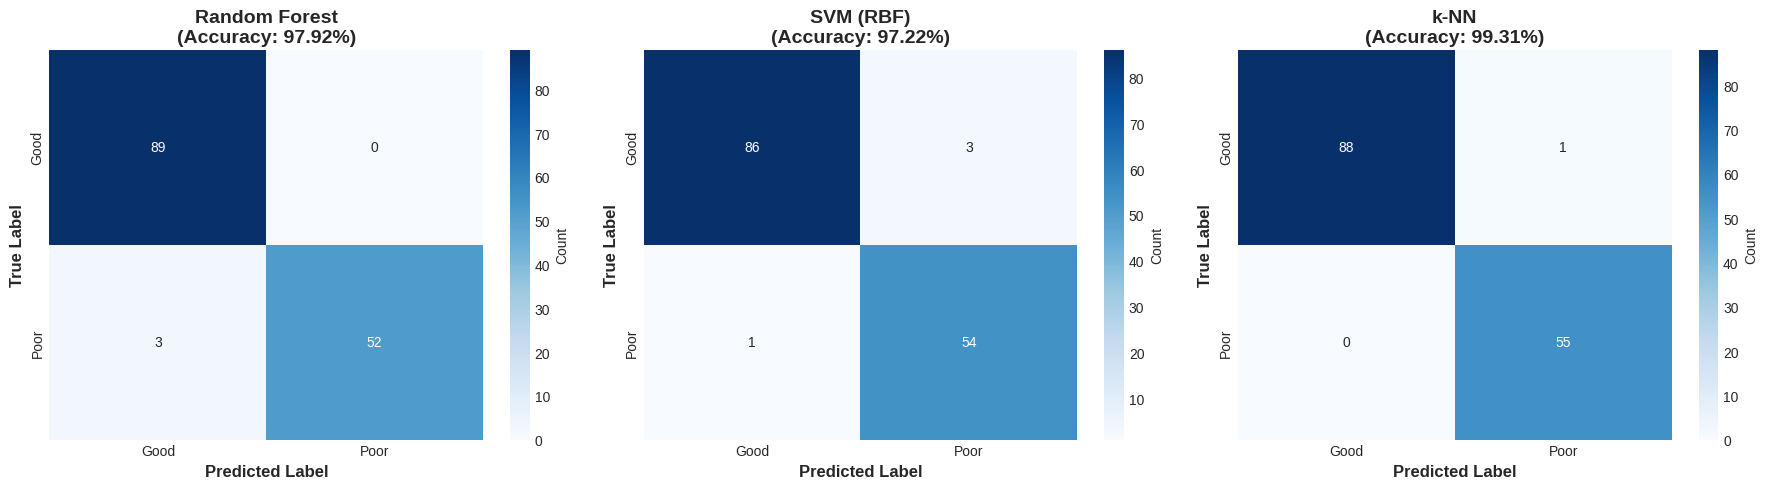


✓ Confusion matrices saved: confusion_matrices.png

DETAILED CLASSIFICATION REPORTS

Random Forest:
------------------------------------------------------------
              precision    recall  f1-score   support

        Good       0.97      1.00      0.98        89
        Poor       1.00      0.95      0.97        55

    accuracy                           0.98       144
   macro avg       0.98      0.97      0.98       144
weighted avg       0.98      0.98      0.98       144


SVM:
------------------------------------------------------------
              precision    recall  f1-score   support

        Good       0.99      0.97      0.98        89
        Poor       0.95      0.98      0.96        55

    accuracy                           0.97       144
   macro avg       0.97      0.97      0.97       144
weighted avg       0.97      0.97      0.97       144


k-NN:
------------------------------------------------------------
              precision    recall  f1-score   sup

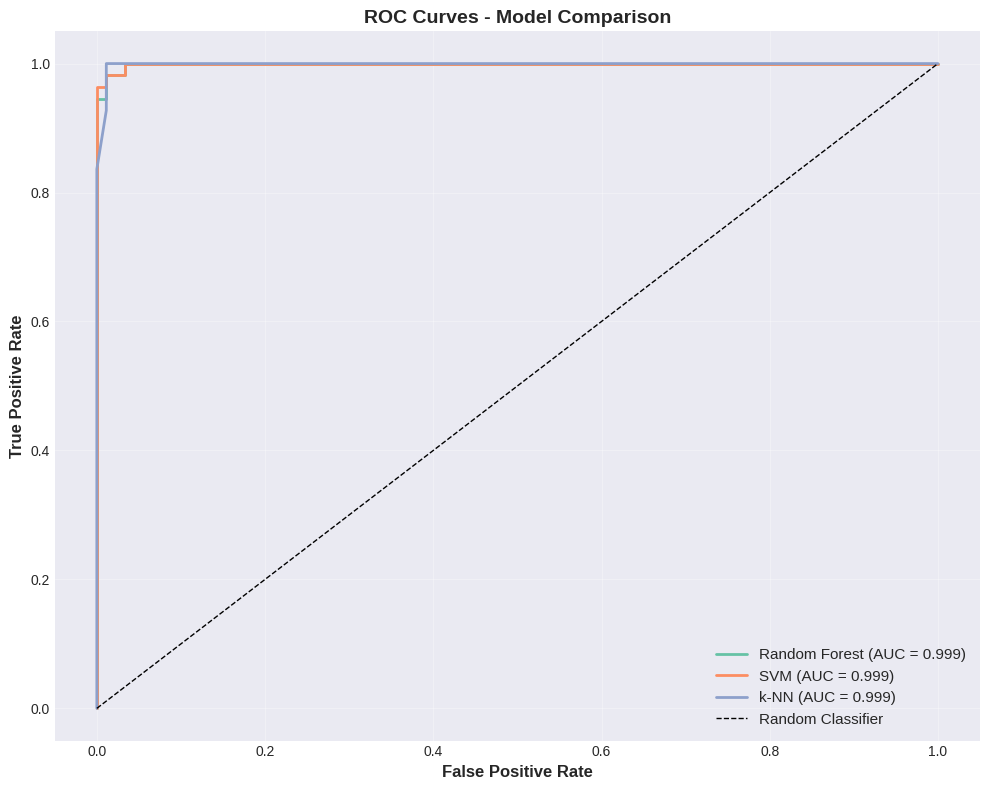


✓ ROC curves saved: roc_curves.png

PART 12: FEATURE IMPORTANCE (RANDOM FOREST)


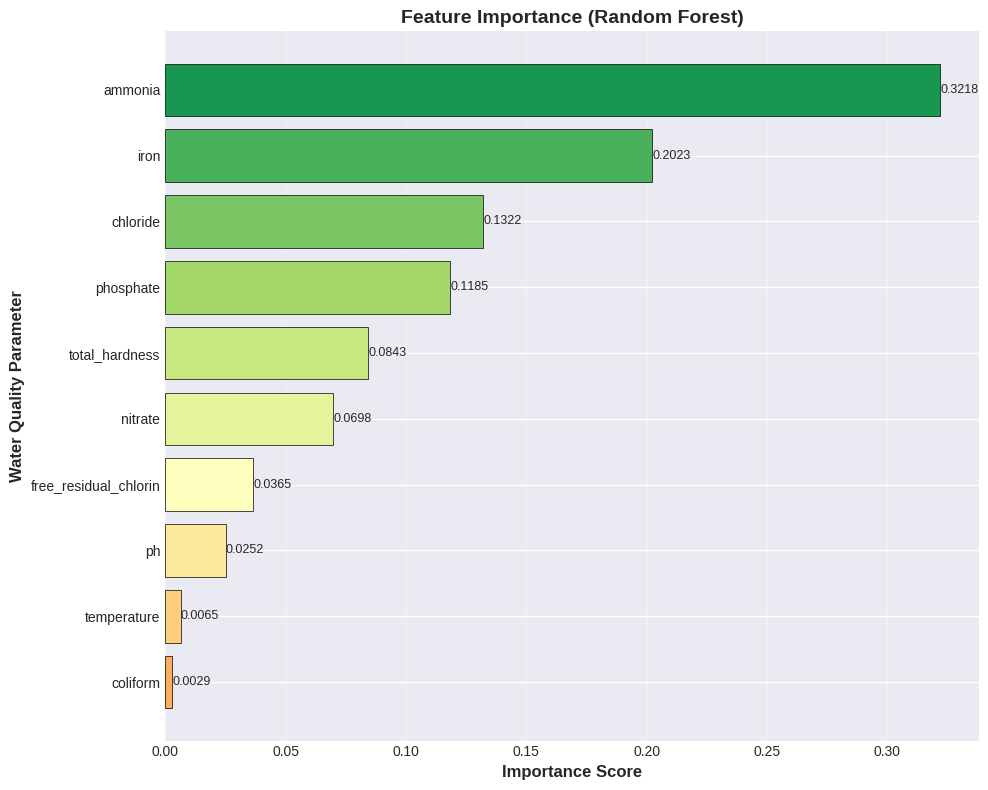


✓ Feature importance plot saved: feature_importance.png
✓ Feature importance data saved: feature_importance.csv

PART 13: SAVING ALL RESULTS
✓ Test predictions saved: test_predictions.csv

✅ PHASE 4: SUPERVISED CLASSIFICATION COMPLETE!

📊 FINAL SUMMARY:
  - Total samples: 720
  - Training samples: 576
  - Test samples: 144
  - Features: 10
  - Classes: 2 (Good, Poor)

  - Model with high accuracy: k-NN
  - Best Test Accuracy: 99.31%



In [20]:
"""
PHASE 4: SUPERVISED CLASSIFICATION
Random Forest, SVM, and k-NN for Water Quality Prediction
"""

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")

print("="*80)
print("PHASE 4: SUPERVISED CLASSIFICATION")
print("="*80)

# ============================================================================
# PART 1: LOAD LABELED DATA
# ============================================================================

print("\n" + "="*80)
print("PART 1: LOADING LABELED DATA")
print("="*80)

# Load the labeled dataset from Phase 3
full_df = pd.read_excel('/content/drive/MyDrive/Mahakali_River_Data/data_with_labels.xlsx')

# Define features and target
feature_columns = ['temperature', 'ph', 'total_hardness', 'chloride',
                  'ammonia', 'phosphate', 'nitrate', 'iron',
                  'free_residual_chlorin', 'coliform']

X = full_df[feature_columns].copy()
y = full_df['cluster_label'].copy()

print(f"\n✓ Loaded dataset: {full_df.shape}")
print(f"  - Features (X): {X.shape}")
print(f"  - Target (y): {y.shape}")

# Class distribution
print("\n📊 Target Variable Distribution:")
print("-" * 60)
class_dist = y.value_counts()
for label, count in class_dist.items():
    pct = (count / len(y)) * 100
    print(f"  {label:10s}: {count:3d} samples ({pct:5.2f}%)")
print("-" * 60)

# Check for class imbalance
imbalance_ratio = class_dist.max() / class_dist.min()
print(f"\nClass imbalance ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 1.5:
    print("⚠️  Moderate imbalance detected - will use SMOTE")
    use_smote = True
else:
    print("✓ Classes are relatively balanced")
    use_smote = False

# ============================================================================
# PART 2: TRAIN-TEST SPLIT
# ============================================================================

print("\n" + "="*80)
print("PART 2: TRAIN-TEST SPLIT")
print("="*80)

# Encode target labels (Poor=0, Good=1)
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"\nLabel encoding:")
for i, label in enumerate(le.classes_):
    print(f"  '{label}' → {i}")

# Split data (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"\n✓ Train-test split complete:")
print(f"  - Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  - Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Check class distribution in splits
print("\nClass distribution in splits:")
print("-" * 60)
train_dist = pd.Series(y_train).value_counts()
test_dist = pd.Series(y_test).value_counts()

for class_id in sorted(train_dist.index):
    label = le.inverse_transform([class_id])[0]
    train_count = train_dist.get(class_id, 0)
    test_count = test_dist.get(class_id, 0)
    print(f"  {label:10s}: Train={train_count:3d} ({train_count/len(y_train)*100:5.1f}%), " +
          f"Test={test_count:3d} ({test_count/len(y_test)*100:5.1f}%)")
print("-" * 60)

# ============================================================================
# PART 3: FEATURE SCALING
# ============================================================================

print("\n" + "="*80)
print("PART 3: FEATURE SCALING")
print("="*80)

# Scale features (important for SVM and k-NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n✓ Features scaled using StandardScaler")
print(f"  - Training set scaled: {X_train_scaled.shape}")
print(f"  - Test set scaled: {X_test_scaled.shape}")

# Save scaler
joblib.dump(scaler, '/content/classifier_scaler.pkl')
print("✓ Scaler saved: classifier_scaler.pkl")

# ============================================================================
# PART 4: HANDLE CLASS IMBALANCE WITH SMOTE (IF NEEDED)
# ============================================================================

if use_smote:
    print("\n" + "="*80)
    print("PART 4: HANDLING CLASS IMBALANCE WITH SMOTE")
    print("="*80)

    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

    print(f"\n✓ SMOTE applied:")
    print(f"  - Before: {X_train_scaled.shape[0]} samples")
    print(f"  - After: {X_train_resampled.shape[0]} samples")

    print("\nClass distribution after SMOTE:")
    resampled_dist = pd.Series(y_train_resampled).value_counts()
    for class_id in sorted(resampled_dist.index):
        label = le.inverse_transform([class_id])[0]
        count = resampled_dist[class_id]
        print(f"  {label:10s}: {count:3d} samples")

    # Use resampled data for training
    X_train_final = X_train_resampled
    y_train_final = y_train_resampled
else:
    print("\n✓ SMOTE not needed - using original training data")
    X_train_final = X_train_scaled
    y_train_final = y_train

# ============================================================================
# PART 5: MODEL 1 - RANDOM FOREST
# ============================================================================

print("\n" + "="*80)
print("PART 5: RANDOM FOREST CLASSIFIER")
print("="*80)

print("\n🌲 Training Random Forest...")

# Define Random Forest with optimized parameters
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Train model
rf_model.fit(X_train_final, y_train_final)
print("✓ Random Forest trained")

# Predictions
y_train_pred_rf = rf_model.predict(X_train_scaled)
y_test_pred_rf = rf_model.predict(X_test_scaled)
y_test_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
rf_train_acc = accuracy_score(y_train, y_train_pred_rf)
rf_test_acc = accuracy_score(y_test, y_test_pred_rf)
rf_precision = precision_score(y_test, y_test_pred_rf, average='weighted')
rf_recall = recall_score(y_test, y_test_pred_rf, average='weighted')
rf_f1 = f1_score(y_test, y_test_pred_rf, average='weighted')

print(f"\n📊 Random Forest Performance:")
print("-" * 60)
print(f"  Training Accuracy: {rf_train_acc*100:.2f}%")
print(f"  Test Accuracy:     {rf_test_acc*100:.2f}%")
print(f"  Precision:         {rf_precision*100:.2f}%")
print(f"  Recall:            {rf_recall*100:.2f}%")
print(f"  F1-Score:          {rf_f1*100:.2f}%")
print("-" * 60)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔍 Feature Importance (Top 5):")
print("-" * 60)
for idx, row in feature_importance.head(5).iterrows():
    print(f"  {row['feature']:25s}: {row['importance']:.4f}")
print("-" * 60)

# Save model
joblib.dump(rf_model, '/content/random_forest_model.pkl')
print("\n✓ Random Forest model saved: random_forest_model.pkl")

# ============================================================================
# PART 6: MODEL 2 - SUPPORT VECTOR MACHINE (SVM)
# ============================================================================

print("\n" + "="*80)
print("PART 6: SUPPORT VECTOR MACHINE (SVM)")
print("="*80)

print("\n🎯 Training SVM with RBF kernel...")

# Define SVM with RBF kernel
svm_model = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    probability=True,  # Enable probability estimates for ROC curve
    random_state=42
)

# Train model
svm_model.fit(X_train_final, y_train_final)
print("✓ SVM trained")

# Predictions
y_train_pred_svm = svm_model.predict(X_train_scaled)
y_test_pred_svm = svm_model.predict(X_test_scaled)
y_test_proba_svm = svm_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
svm_train_acc = accuracy_score(y_train, y_train_pred_svm)
svm_test_acc = accuracy_score(y_test, y_test_pred_svm)
svm_precision = precision_score(y_test, y_test_pred_svm, average='weighted')
svm_recall = recall_score(y_test, y_test_pred_svm, average='weighted')
svm_f1 = f1_score(y_test, y_test_pred_svm, average='weighted')

print(f"\n📊 SVM Performance:")
print("-" * 60)
print(f"  Training Accuracy: {svm_train_acc*100:.2f}%")
print(f"  Test Accuracy:     {svm_test_acc*100:.2f}%")
print(f"  Precision:         {svm_precision*100:.2f}%")
print(f"  Recall:            {svm_recall*100:.2f}%")
print(f"  F1-Score:          {svm_f1*100:.2f}%")
print("-" * 60)

# Save model
joblib.dump(svm_model, '/content/svm_model.pkl')
print("\n✓ SVM model saved: svm_model.pkl")

# ============================================================================
# PART 7: MODEL 3 - K-NEAREST NEIGHBORS (k-NN)
# ============================================================================

print("\n" + "="*80)
print("PART 7: K-NEAREST NEIGHBORS (k-NN)")
print("="*80)

print("\n🔢 Finding optimal k value...")

# Test different k values
k_range = range(3, 16, 2)
k_scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_final, y_train_final)
    score = knn.score(X_test_scaled, y_test)
    k_scores.append(score)
    print(f"  k={k:2d}: Test Accuracy = {score*100:.2f}%")

# Select best k
best_k = list(k_range)[np.argmax(k_scores)]
best_k_score = max(k_scores)

print(f"\n✓ Optimal k = {best_k} (Accuracy: {best_k_score*100:.2f}%)")

# Train final k-NN model with best k
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train_final, y_train_final)
print(f"✓ k-NN trained with k={best_k}")

# Predictions
y_train_pred_knn = knn_model.predict(X_train_scaled)
y_test_pred_knn = knn_model.predict(X_test_scaled)
y_test_proba_knn = knn_model.predict_proba(X_test_scaled)[:, 1]

# Calculate metrics
knn_train_acc = accuracy_score(y_train, y_train_pred_knn)
knn_test_acc = accuracy_score(y_test, y_test_pred_knn)
knn_precision = precision_score(y_test, y_test_pred_knn, average='weighted')
knn_recall = recall_score(y_test, y_test_pred_knn, average='weighted')
knn_f1 = f1_score(y_test, y_test_pred_knn, average='weighted')

print(f"\n📊 k-NN Performance:")
print("-" * 60)
print(f"  Training Accuracy: {knn_train_acc*100:.2f}%")
print(f"  Test Accuracy:     {knn_test_acc*100:.2f}%")
print(f"  Precision:         {knn_precision*100:.2f}%")
print(f"  Recall:            {knn_recall*100:.2f}%")
print(f"  F1-Score:          {knn_f1*100:.2f}%")
print("-" * 60)

# Save model
joblib.dump(knn_model, '/content/knn_model.pkl')
print(f"\n✓ k-NN model saved: knn_model.pkl")

# ============================================================================
# PART 8: 5-FOLD CROSS-VALIDATION
# ============================================================================

print("\n" + "="*80)
print("PART 8: 5-FOLD CROSS-VALIDATION")
print("="*80)

# Define stratified k-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n🔄 Performing 5-fold cross-validation...")
print("-" * 60)

# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
print(f"Random Forest CV: {rf_cv_scores.mean()*100:.2f}% (+/- {rf_cv_scores.std()*100:.2f}%)")

# Cross-validation for SVM
svm_cv_scores = cross_val_score(svm_model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
print(f"SVM CV:           {svm_cv_scores.mean()*100:.2f}% (+/- {svm_cv_scores.std()*100:.2f}%)")

# Cross-validation for k-NN
knn_cv_scores = cross_val_score(knn_model, X_train_scaled, y_train, cv=skf, scoring='accuracy')
print(f"k-NN CV:          {knn_cv_scores.mean()*100:.2f}% (+/- {knn_cv_scores.std()*100:.2f}%)")
print("-" * 60)

# ============================================================================
# PART 9: MODEL COMPARISON
# ============================================================================

print("\n" + "="*80)
print("PART 9: MODEL COMPARISON")
print("="*80)

# Create comparison table
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'SVM (RBF)', 'k-NN'],
    'Test Accuracy (%)': [rf_test_acc*100, svm_test_acc*100, knn_test_acc*100],
    'Precision (%)': [rf_precision*100, svm_precision*100, knn_precision*100],
    'Recall (%)': [rf_recall*100, svm_recall*100, knn_recall*100],
    'F1-Score (%)': [rf_f1*100, svm_f1*100, knn_f1*100],
    'CV Mean (%)': [rf_cv_scores.mean()*100, svm_cv_scores.mean()*100, knn_cv_scores.mean()*100],
    'CV Std (%)': [rf_cv_scores.std()*100, svm_cv_scores.std()*100, knn_cv_scores.std()*100]
})

print("\n📊 MODEL PERFORMANCE COMPARISON:")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Identify best model
best_model_idx = comparison_df['Test Accuracy (%)'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_model_acc = comparison_df.loc[best_model_idx, 'Test Accuracy (%)']

print(f"\n🏆 BEST MODEL: {best_model_name} (Test Accuracy: {best_model_acc:.2f}%)")

# Save comparison table
comparison_df.to_csv('/content/model_comparison.csv', index=False)
print("✓ Model comparison saved: model_comparison.csv")

# ============================================================================
# PART 10: CONFUSION MATRICES
# ============================================================================

print("\n" + "="*80)
print("PART 10: CONFUSION MATRICES")
print("="*80)

# Calculate confusion matrices
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
cm_knn = confusion_matrix(y_test, y_test_pred_knn)

# Plot confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models_cm = [
    ('Random Forest', cm_rf, rf_test_acc),
    ('SVM (RBF)', cm_svm, svm_test_acc),
    ('k-NN', cm_knn, knn_test_acc)
]

for ax, (model_name, cm, acc) in zip(axes, models_cm):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=le.classes_, yticklabels=le.classes_,
                cbar_kws={'label': 'Count'})
    ax.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
    ax.set_ylabel('True Label', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name}\n(Accuracy: {acc*100:.2f}%)',
                fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrices saved: confusion_matrices.png")

# Print classification reports
print("\n" + "="*60)
print("DETAILED CLASSIFICATION REPORTS")
print("="*60)

for model_name, y_pred in [('Random Forest', y_test_pred_rf),
                           ('SVM', y_test_pred_svm),
                           ('k-NN', y_test_pred_knn)]:
    print(f"\n{model_name}:")
    print("-" * 60)
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# ============================================================================
# PART 11: ROC CURVES
# ============================================================================

print("\n" + "="*80)
print("PART 11: ROC CURVES")
print("="*80)

# Calculate ROC curves
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_test_proba_rf)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_test_proba_svm)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_test_proba_knn)

# Calculate AUC scores
auc_rf = auc(fpr_rf, tpr_rf)
auc_svm = auc(fpr_svm, tpr_svm)
auc_knn = auc(fpr_knn, tpr_knn)

print(f"\n📈 AUC-ROC Scores:")
print("-" * 60)
print(f"  Random Forest: {auc_rf:.4f}")
print(f"  SVM:           {auc_svm:.4f}")
print(f"  k-NN:          {auc_knn:.4f}")
print("-" * 60)

# Plot ROC curves
plt.figure(figsize=(10, 8))

plt.plot(fpr_rf, tpr_rf, linewidth=2, label=f'Random Forest (AUC = {auc_rf:.3f})')
plt.plot(fpr_svm, tpr_svm, linewidth=2, label=f'SVM (AUC = {auc_svm:.3f})')
plt.plot(fpr_knn, tpr_knn, linewidth=2, label=f'k-NN (AUC = {auc_knn:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ ROC curves saved: roc_curves.png")

# ============================================================================
# PART 12: FEATURE IMPORTANCE VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("PART 12: FEATURE IMPORTANCE (RANDOM FOREST)")
print("="*80)

# Plot feature importance
fig, ax = plt.subplots(figsize=(10, 8))

feature_importance_sorted = feature_importance.sort_values('importance')
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(feature_importance_sorted)))

bars = ax.barh(feature_importance_sorted['feature'],
               feature_importance_sorted['importance'],
               color=colors, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Importance Score', fontsize=12, fontweight='bold')
ax.set_ylabel('Water Quality Parameter', fontsize=12, fontweight='bold')
ax.set_title('Feature Importance (Random Forest)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add value labels
for bar in bars:
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2,
            f'{width:.4f}', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature importance plot saved: feature_importance.png")

# Save feature importance
feature_importance.to_csv('/content/feature_importance.csv', index=False)
print("✓ Feature importance data saved: feature_importance.csv")

# ============================================================================
# PART 13: SAVE ALL RESULTS
# ============================================================================

print("\n" + "="*80)
print("PART 13: SAVING ALL RESULTS")
print("="*80)

# Save all predictions
results_df = pd.DataFrame({
    'true_label': le.inverse_transform(y_test),
    'rf_prediction': le.inverse_transform(y_test_pred_rf),
    'svm_prediction': le.inverse_transform(y_test_pred_svm),
    'knn_prediction': le.inverse_transform(y_test_pred_knn),
    'rf_probability': y_test_proba_rf,
    'svm_probability': y_test_proba_svm,
    'knn_probability': y_test_proba_knn
})
results_df.to_csv('/content/test_predictions.csv', index=False)
print("✓ Test predictions saved: test_predictions.csv")

print("\n" + "="*80)
print("✅ PHASE 4: SUPERVISED CLASSIFICATION COMPLETE!")
print("="*80)

print(f"\n📊 FINAL SUMMARY:")
print(f"  - Total samples: {len(X)}")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Test samples: {len(X_test)}")
print(f"  - Features: {len(feature_columns)}")
print(f"  - Classes: {len(le.classes_)} ({', '.join(le.classes_)})")
print(f"\n  - Model with high accuracy: {best_model_name}")
print(f"  - Best Test Accuracy: {best_model_acc:.2f}%")

print("\n" + "="*80)